# Filamentation Plasma 3

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from ionization import adk
from lens import profile
from lens import bessel
from lens import ray
from lens import design
import matplotlib.pyplot as plt
from ionization import adk
from scipy.interpolate import interp1d
from scipy.optimize import newton
from copy import copy
import matplotlib.colors as colors
import numpy.ma as ma
from copy import copy
from scipy import signal
plt.style.use('presentation')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Filamentation/FP_3_Mask/'
lam = 0.8
tau = 70.

Filamentation plasma simulation using the gas jet profile from UCLA and including beam dump simulations.

In [2]:
def plot_laser_plasma(I, ne, ext, name=None):
    plt.figure(figsize=(16, 4), dpi=300)
    plt.subplot(121)
    plt.imshow(np.flipud(np.transpose(I)), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (mm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)

    plt.subplot(122)
    plt.imshow(np.flipud(np.transpose(ne)), aspect='auto', extent=ext, cmap='plasma')
    cb = plt.colorbar()
    cb.set_label(r'$n_e$ ($\mathrm{cm^-3}$)')
    plt.xlabel('$z$ (mm)')
    plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
    plt.ylim(-200, 200)
    plt.tight_layout()
    if name is not None:
        plt.savefig(path+name+'.png')
    plt.show()

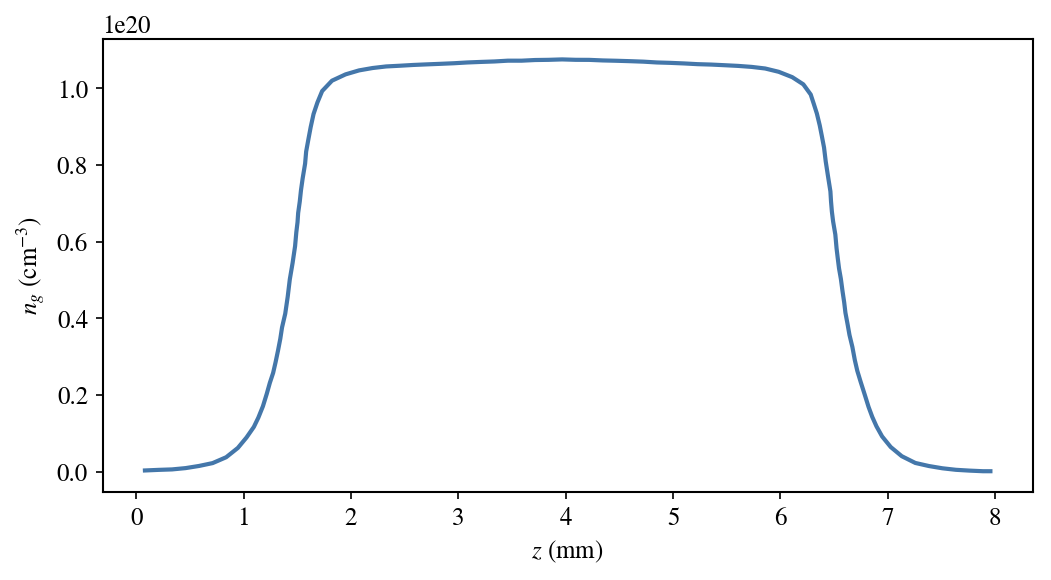

In [3]:
# Load the gas jet profile from a csv file
plt.figure(figsize=(8, 4), dpi=150)
jet_data = np.genfromtxt(path+"1mmX5mm_Filamentation_Jet_Profile.csv", delimiter=',')
n_jet = interp1d(jet_data[:, 0]*1e3, jet_data[:, 1]*1e19, fill_value=0.0, bounds_error=False)
plt.plot(jet_data[:, 0], jet_data[:, 1]*1e19)
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$n_g$ ($\mathrm{cm^{-3}}$)')
plt.show()

In [4]:
def prep_ma(Z, X, Nzi, Zi, Z0i, Xi, Nxi, array):
    
    # Calculate the size of the extended array
    Nx = int(Nxi*X/Xi)
    Nz = int(Nzi*Z/Zi)
    # Extend the array to fill the entire imshow with the correct spacing
    Im = np.zeros((Nx, Nz))
    Im = ma.asarray(Im)
    # Mark the entire array as invalid
    Im[:, :] = ma.masked
    # Fill in the intensity 
    Nx0 = int((Nx-Nxi)/2)
    Nz0 = int(Nzi*Z0i/Zi)
    Im[Nx0:Nx0+Nxi, Nz0:Nz0+Nzi] = array
    return Im

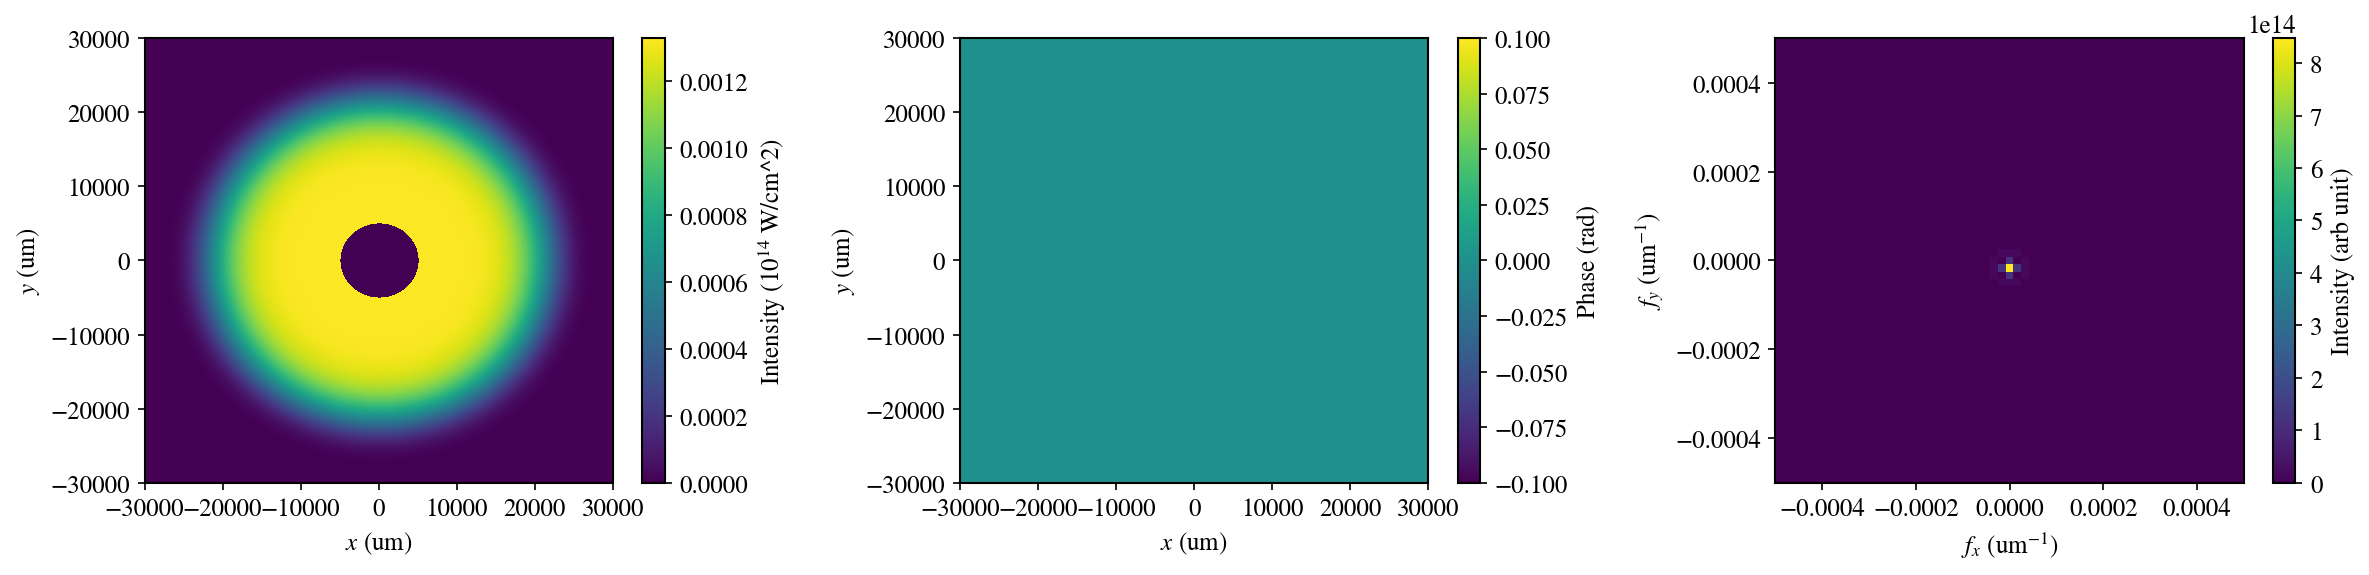

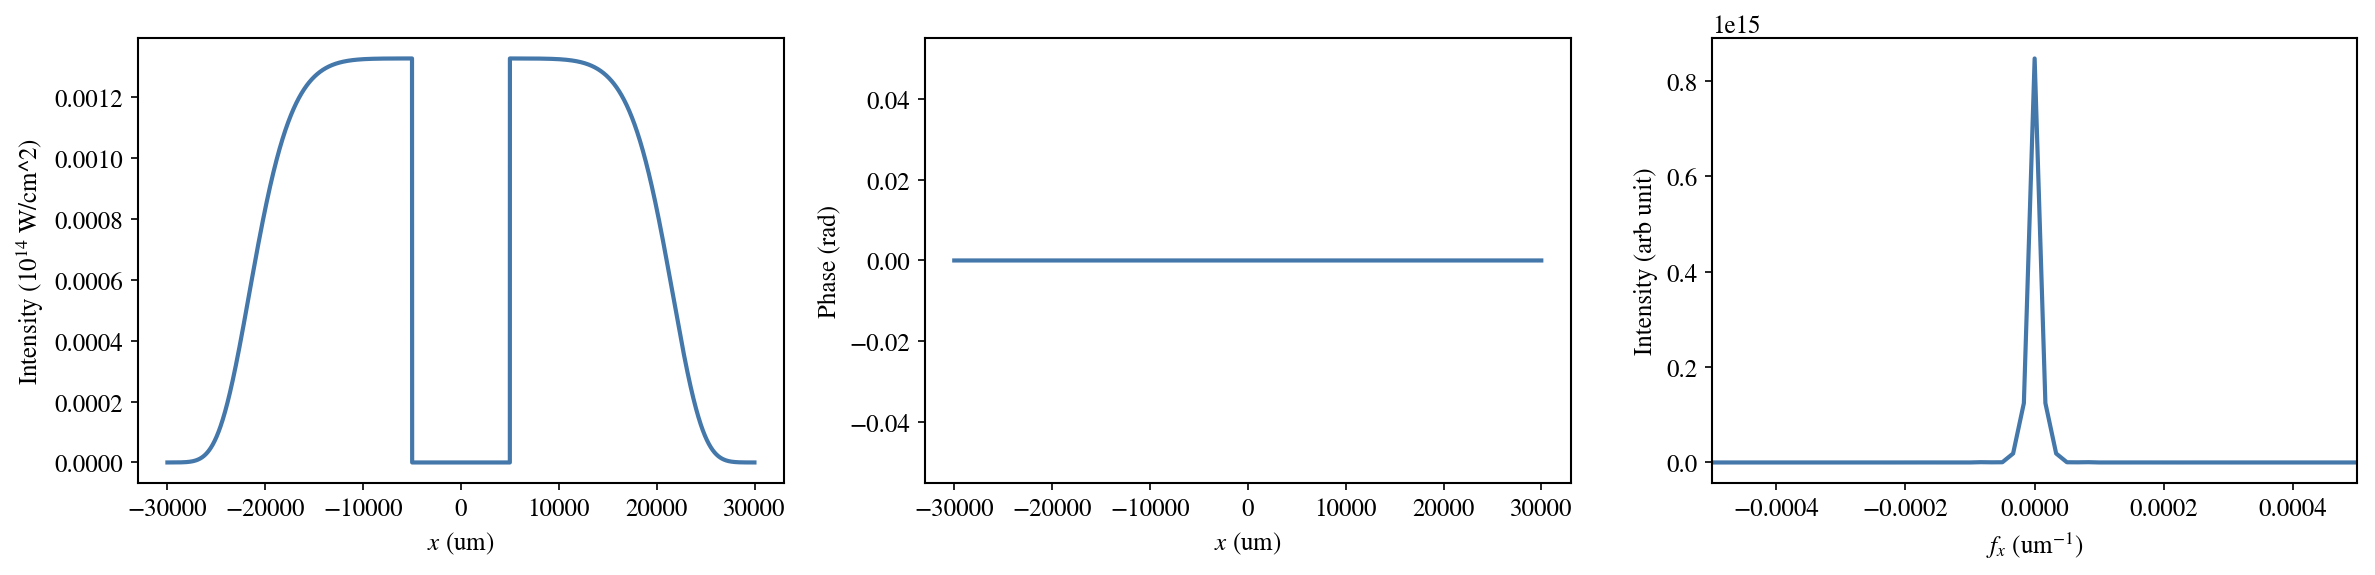

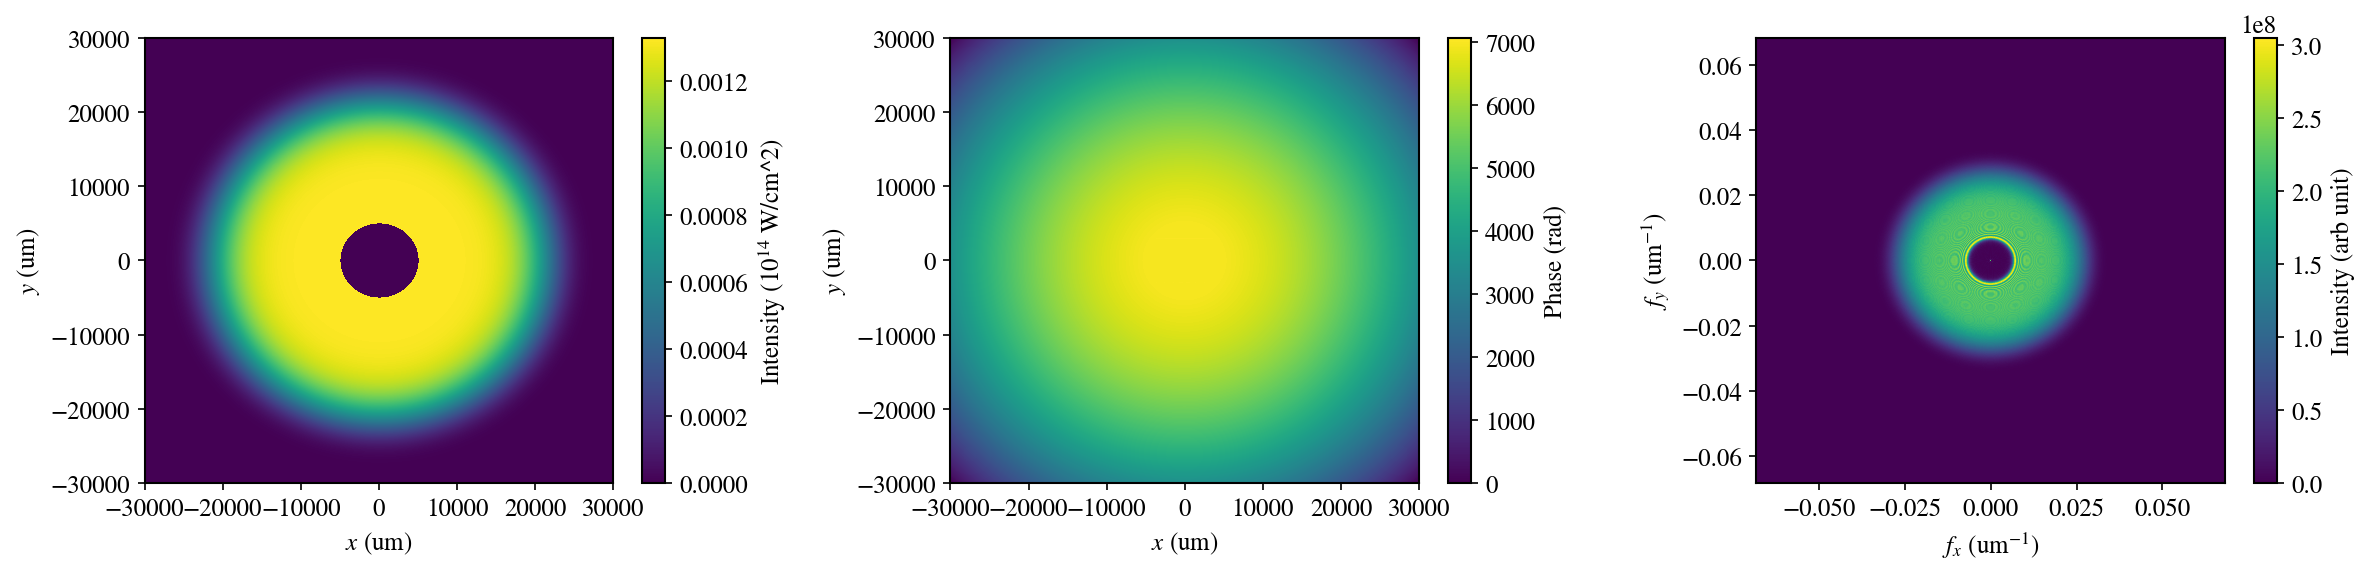

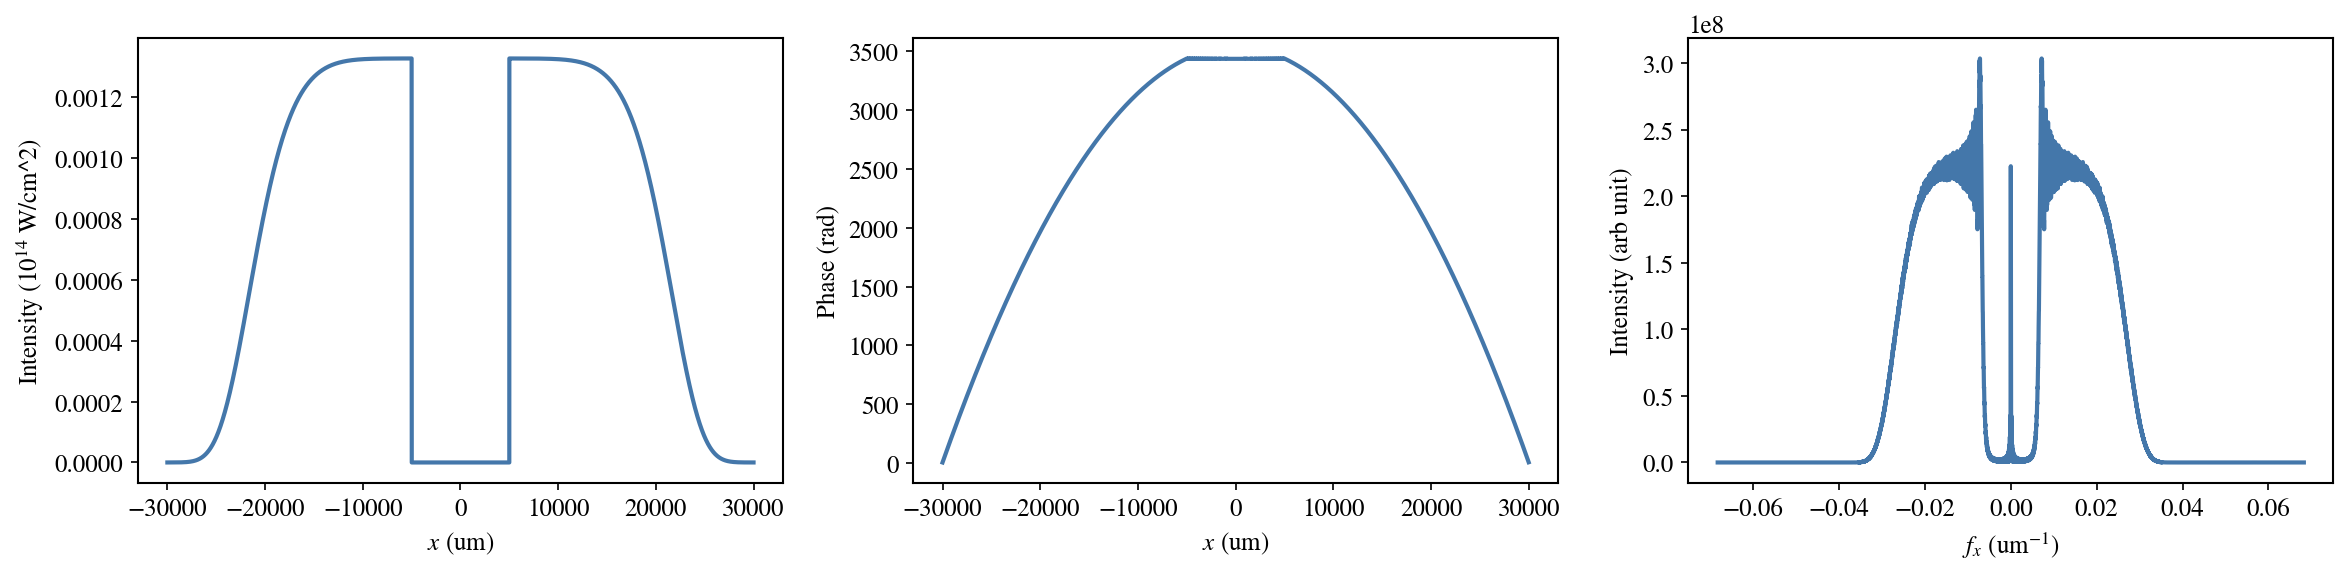

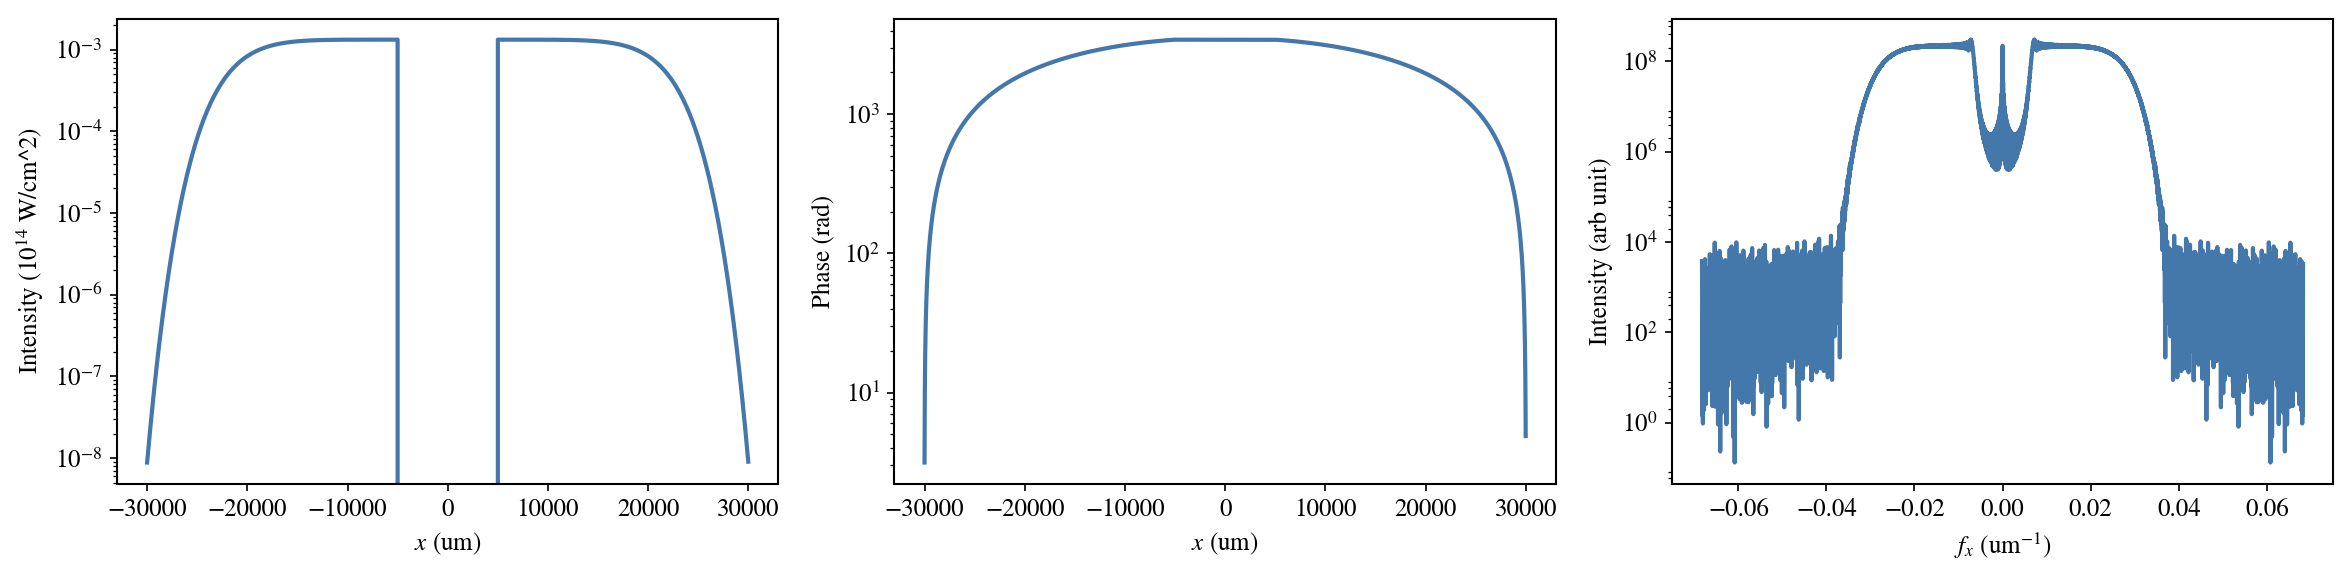

In [5]:
Z = 2.5e6
n = 8
w0 = 24e3
Nx_in = 2**13
X_in = 60e3
Nz_in = 256
f = 1e6
z_end = 7e3
r_mask = 5e3
beamParams = {'Nx' : Nx_in,
              'Ny' : Nx_in,
              'X' : X_in,
              'Y' : X_in,
              'lam' : lam,
              'path' : path,
              'name' : 'Input_beam',
              'threads' : 20,
              'cyl' : True,
              'load' : False,
              'E0' : 1.0,
              'waist' : w0,
              'order' : n}

# Super Gaussian for simulation
beam_in = laserbeam.SuperGaussianLaser(beamParams)
mask = np.ones((Nx_in, Nx_in))
r = np.sqrt(beam_in.x[:, None]**2 + beam_in.y[None, :]**2)
mask[r < r_mask] = 0.0
beam_in.e *= mask
beam_in.plot_current_field(flim=[-0.0005, 0.0005])
lensParams = {'Nx' : Nx_in,
              'Ny' : Nx_in,
              'X' : X_in,
              'Y' : X_in,
              'path' : path,
              'name' : 'Spherical_Lens',
              'lam' : lam,
              'f' : f,
              'load' : False}
lens = optic.SphericalLens(lensParams)
interactions.beam_phase(beam_in, lens)
beam_in.plot_current_field(log=True)

In [6]:
z_in = np.linspace(0, f/2, Nz_in)
beam_in.propagate(z_in, 1)
I_in = np.zeros((Nz_in, Nx_in))
for i in range(Nz_in):
    I_in[i, :] = beam_in.intensity_from_field(beam_in.load_field(i+1)[0])
I_in = beam_in.prep_data(I_in)

Im = {}
X = X_in
ext0 = [0, Z, -X_in/2e3, X_in/2e3]
Im[0] = prep_ma(Z, X, Nz_in, f/2, 0.0, X, Nx_in, I_in)
start = f/2
beam_o = beam_in


M = 3
for i in range(1, M):
    multi = 2**i
    beamParams['X'] = X_in/multi
    beamParams['Y'] = X_in/multi
    beamParams['name'] = 'Input_beam%i' % i
    beam_n = laserbeam.Laser(beamParams)
    e = beam_n.reconstruct_from_cyl_beam(beam_o)
    beam_n.initialize_field(e)
    Nz_n = int(Nz_in/multi)
    if i == M-1:
        Nz_n = 2*Nz_n
        z_n = np.linspace(0, f/multi-z_end, Nz_n)
    else:
        z_n = np.linspace(0, f/(2*multi), Nz_n)
    beam_n.propagate(z_n, 1)
    I_n = np.zeros((Nz_n, Nx_in))
    for j in range(Nz_n):
        I_n[j, :] = beam_n.intensity_from_field(beam_n.load_field(j+1)[0])
    I_n = beam_n.prep_data(I_n)
    length = z_n[-1]
    Im[i] = prep_ma(Z, X, Nz_n, length, start, X_in/multi, Nx_in, I_n)
    start = length+start
    beam_o = beam_n

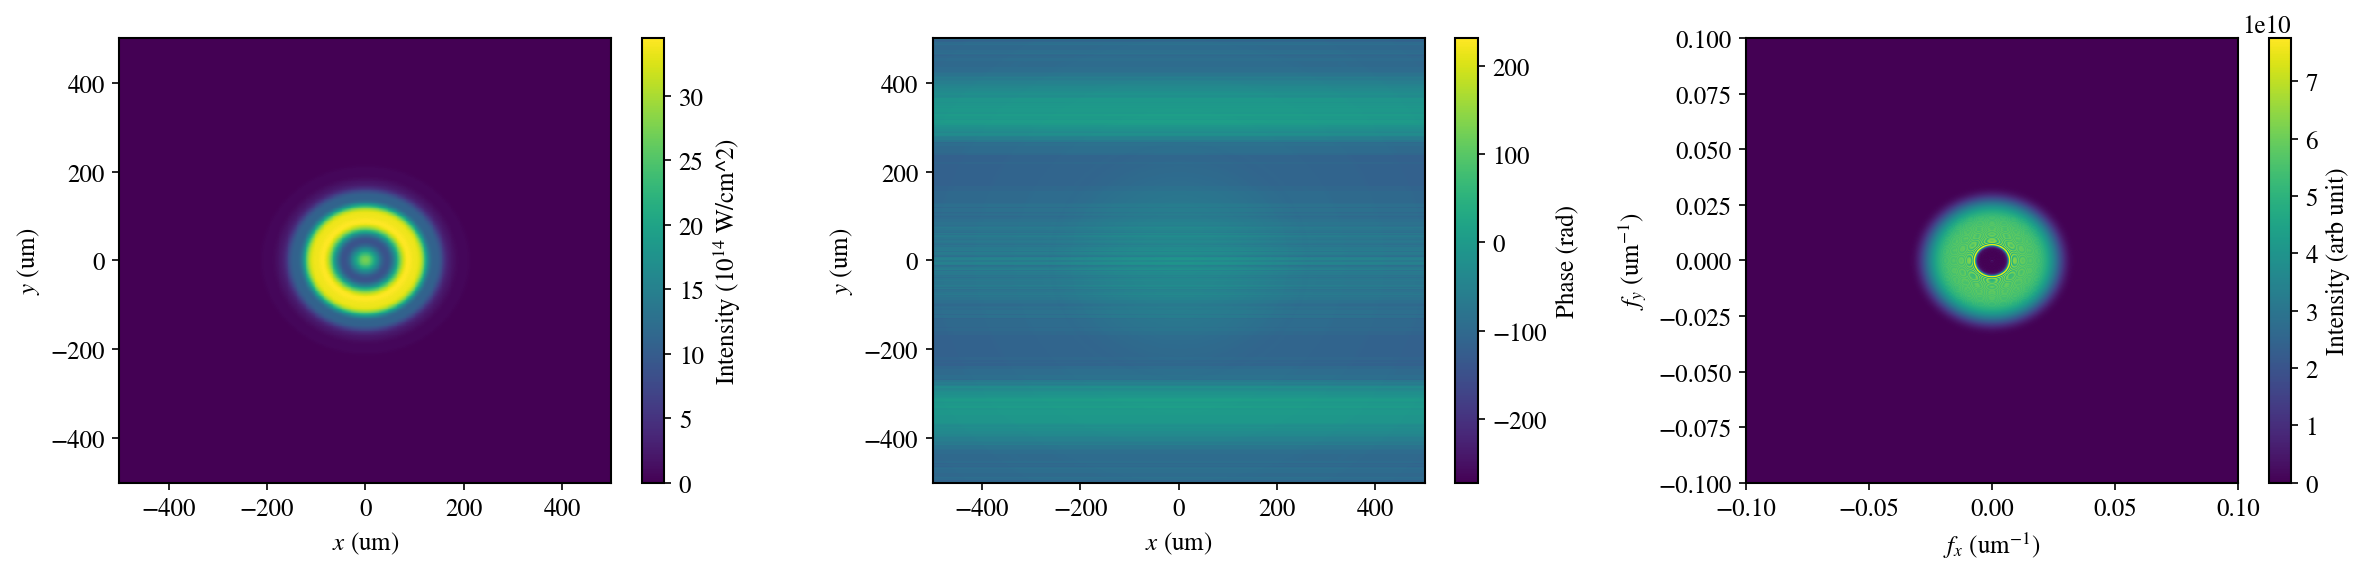

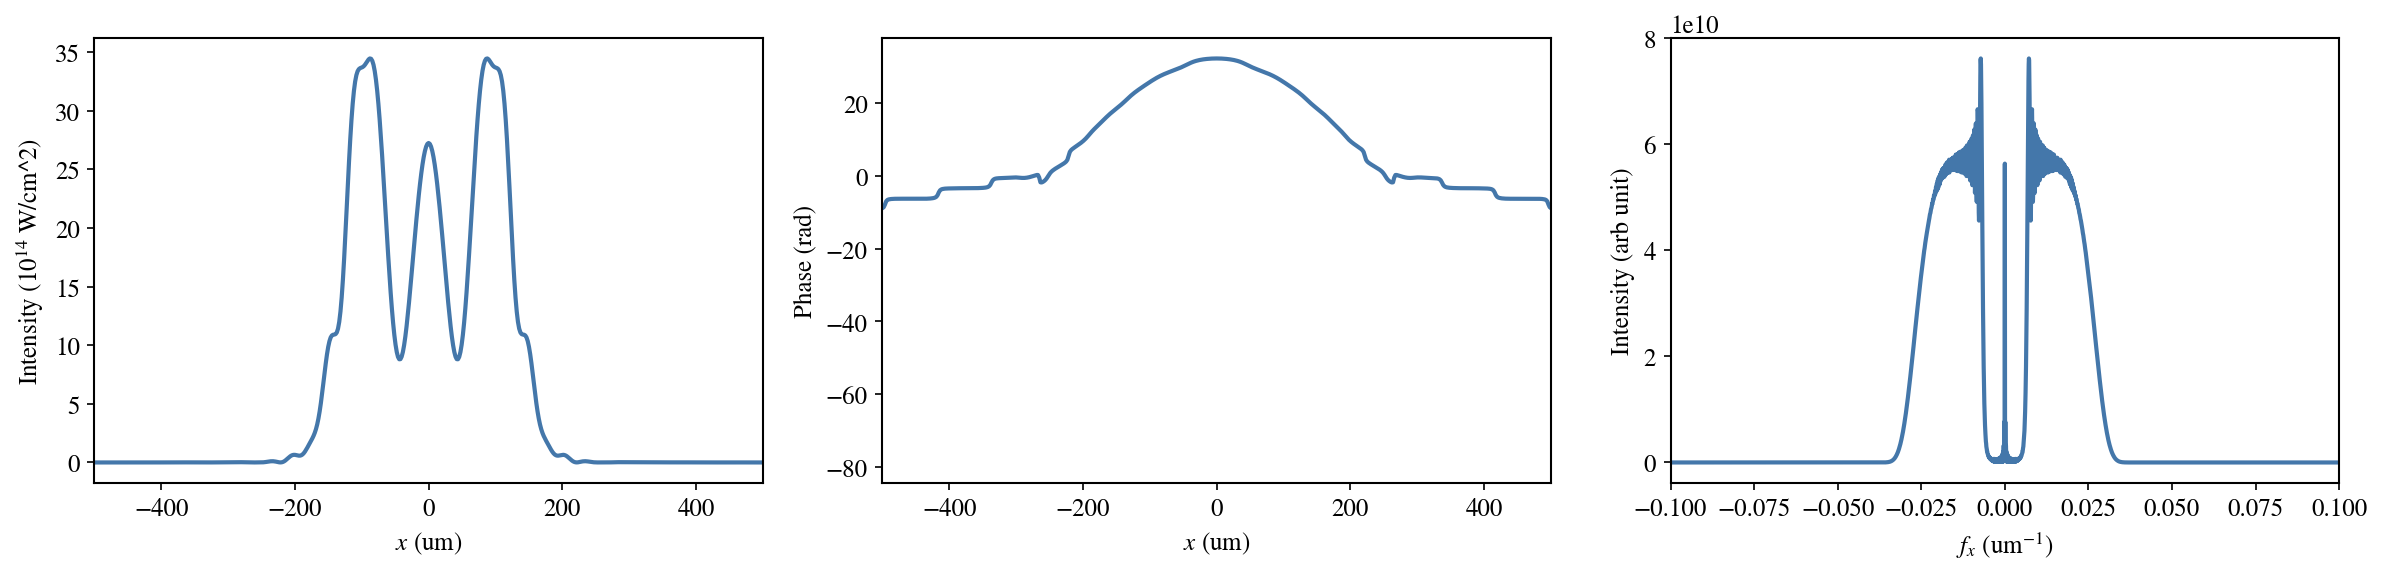

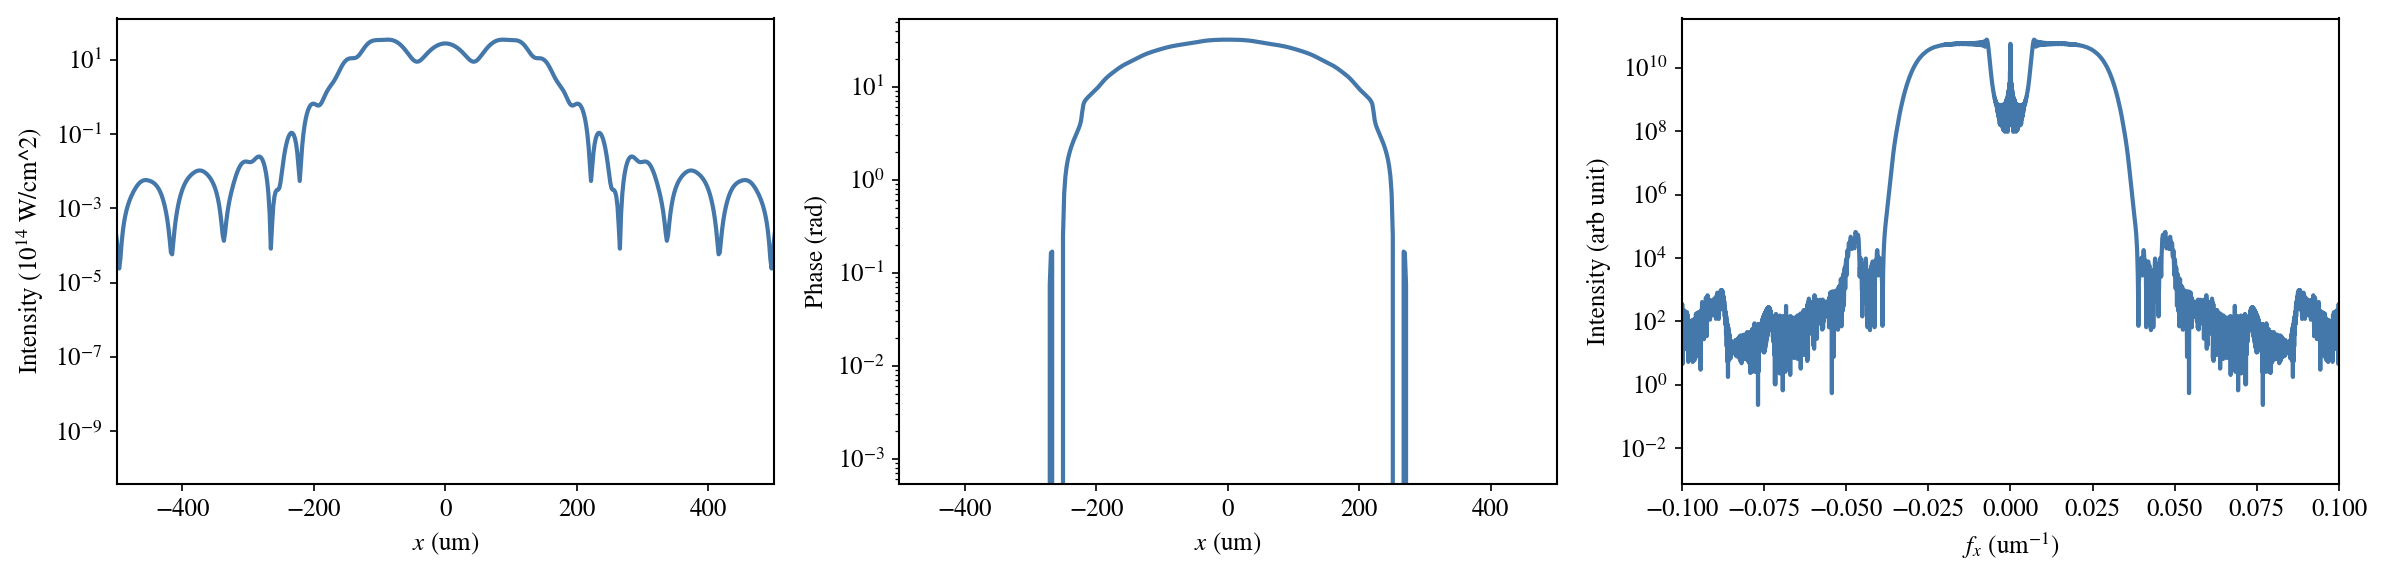

In [7]:
beam_o.plot_current_field(xlim=[-500, 500], flim=[-0.1, 0.1], log=True)

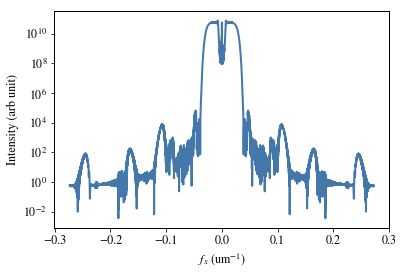

In [8]:
If = abs(fftshift(beam_o.fft(beam_o.e)))**2
fx, fy = beam_o.get_f()
fx = fftshift(fx)
plt.plot(fx, If[:, int(beam_o.Ny/2)])
plt.xlabel(r'$f_x$ (um$^{-1}$)')
plt.ylabel(r'Intensity (arb unit)')
plt.yscale('log')
plt.show()

In [9]:
Nx = 2**9
Xp = 1000
Nz = 1000
Zp = 8e3
n0 = 1e20
atom = ionization.H2
temp = 20
n2 = 1e-19
z = np.linspace(0, Zp, Nz)
pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : Xp,
    'Y' : Xp,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'name' : 'Refracted_Pulse',
    'E0' : 1.0
}
n = np.ones((Nx, Nx, Nz), dtype='double')
n = n * n_jet(z)[None, None, :]

plasmaParams = {
    'Nx' : Nx,
    'Ny' : Nx,
    'Nz' : Nz,
    'X' : Xp,
    'Y' : Xp,
    'Z' : Zp,
    'atom' : atom,
    'path' : path,
    'load' : False,
    'cyl' : True,
    'name' : 'Refracted_Plasma',
    'n0' : n0/1e17
}
pulse = laserpulse.Pulse(pulseParams)
t = pulse.t
e = pulse.reconstruct_from_cyl_beam(beam_o)*np.exp(-t[:, None, None]**2*np.pi/(2*pulse.tau**2))
pulse.initialize_field(e)

In [10]:
def plot_current_field_pulse(pulse, ind_t, xlim=None, flim=None, log=False):
    I = pulse.intensity_from_field(pulse.e[ind_t])
    I = pulse.prep_data(I)
    If = abs(fftshift(pulse.fft(pulse.e[ind_t])))**2
    fx, fy = pulse.get_f()
    fx = fftshift(fx)
    fy = fftshift(fy)
    phase = np.angle(pulse.e[ind_t])
    
    # Images
    X = pulse.X
    Y = pulse.Y
    ext = [-X/2, X/2, -Y/2, Y/2]
    extf = [fx[0], fx[-1], fy[0], fy[-1]]
    plt.figure(figsize=(16, 4), dpi=150)
    plt.subplot(131)
    plt.imshow(I, aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Intensity ($10^{14}$ W/cm^2)')
    plt.xlabel(r'$x$ (um)')
    plt.ylabel(r'$y$ (um)')
    if xlim != None:
        plt.xlim(xlim)
        plt.ylim(xlim)
    
    plt.subplot(132)
    plt.imshow(np.unwrap(np.unwrap(phase, axis=1), axis=0), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Phase (rad)')
    plt.xlabel(r'$x$ (um)')
    plt.ylabel(r'$y$ (um)')
    if xlim != None:
        plt.xlim(xlim)
        plt.ylim(xlim)
    
    plt.subplot(133)
    plt.imshow(If, aspect='auto', extent=extf, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Intensity (arb unit)')
    plt.xlabel(r'$f_x$ (um$^{-1}$)')
    plt.ylabel(r'$f_y$ (um$^{-1}$)')
    if flim != None:
        plt.xlim(flim)
        plt.ylim(flim)
    
    plt.tight_layout()
    plt.show()
    # Lineouts
    ind = int(pulse.Ny/2)
    x = pulse.x
    plt.figure(figsize=(16, 4), dpi=150)
    plt.subplot(131)
    plt.plot(x, I[:, ind])
    plt.xlabel(r'$x$ (um)')
    plt.ylabel(r'Intensity ($10^{14}$ W/cm^2)')
    if xlim != None:
        plt.xlim(xlim)
    
    plt.subplot(132)
    plt.plot(x, np.unwrap(phase[:, ind]))
    plt.xlabel(r'$x$ (um)')
    plt.ylabel(r'Phase (rad)')
    if xlim != None:
        plt.xlim(xlim)
    
    plt.subplot(133)
    plt.plot(fx, If[:, ind])
    plt.xlabel(r'$f_x$ (um$^{-1}$)')
    plt.ylabel(r'Intensity (arb unit)')
    if flim != None:
        plt.xlim(flim)
    
    plt.tight_layout()
    plt.show()
        
    if log == True:
        # Lineouts
        ind = int(pulse.Ny/2)
        x = pulse.x
        plt.figure(figsize=(16, 4), dpi=150)
        plt.subplot(131)
        plt.plot(x, I[:, ind])
        plt.xlabel(r'$x$ (um)')
        plt.ylabel(r'Intensity ($10^{14}$ W/cm^2)')
        plt.yscale('log')
        if xlim != None:
            plt.xlim(xlim)

        plt.subplot(132)
        plt.plot(x, np.unwrap(phase[:, ind]))
        plt.xlabel(r'$x$ (um)')
        plt.ylabel(r'Phase (rad)')
        plt.yscale('log')
        if xlim != None:
            plt.xlim(xlim)

        plt.subplot(133)
        plt.plot(fx, If[:, ind])
        plt.xlabel(r'$f_x$ (um$^{-1}$)')
        plt.ylabel(r'Intensity (arb unit)')
        plt.yscale('log')
        if flim != None:
            plt.xlim(flim)

        plt.tight_layout()
        plt.show()

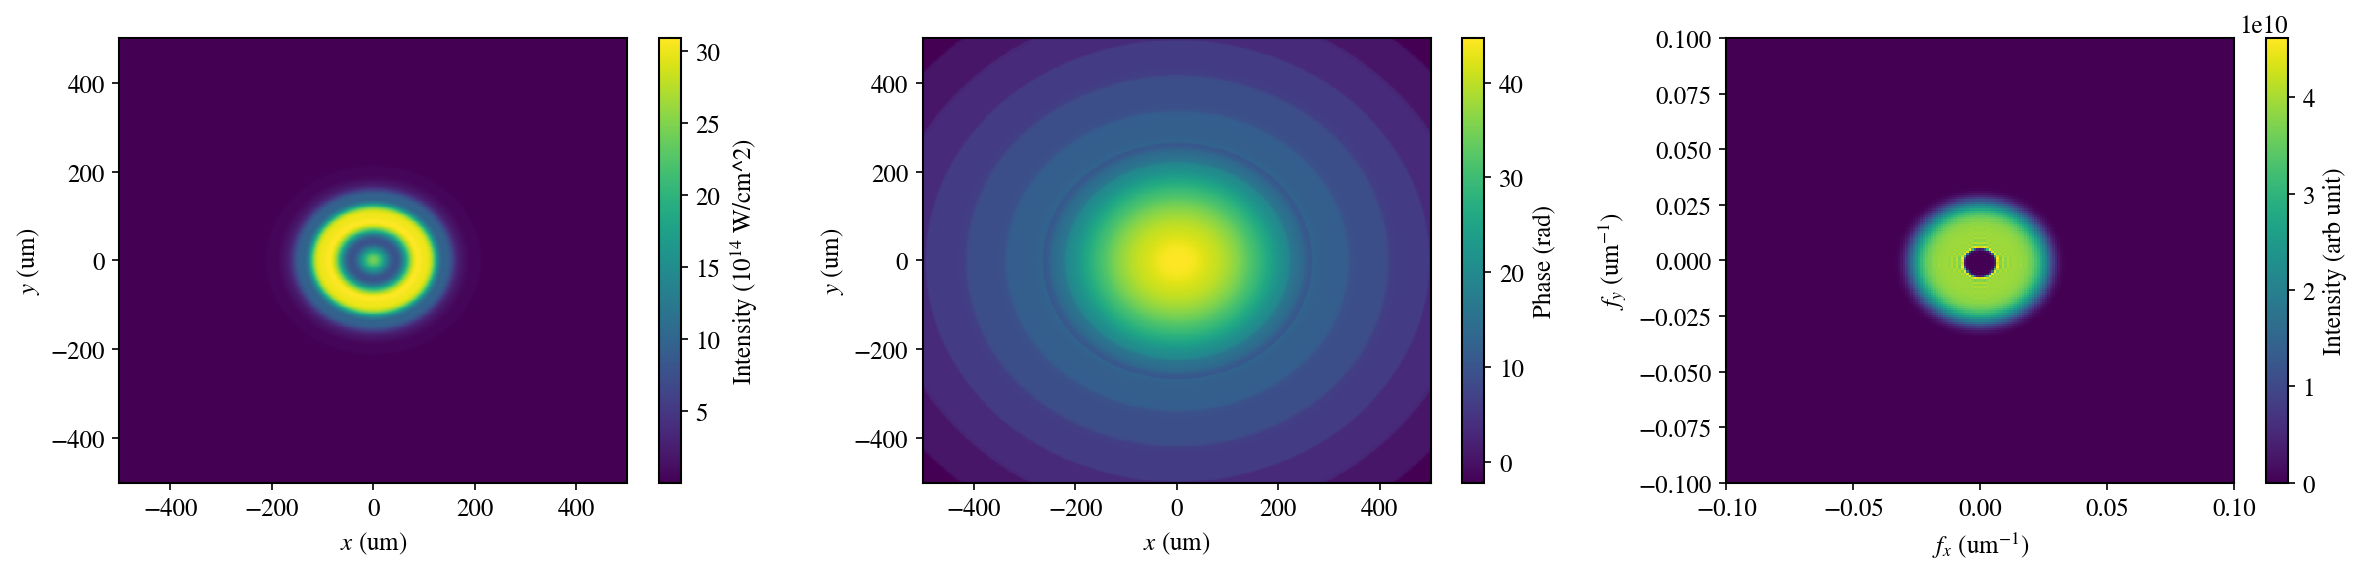

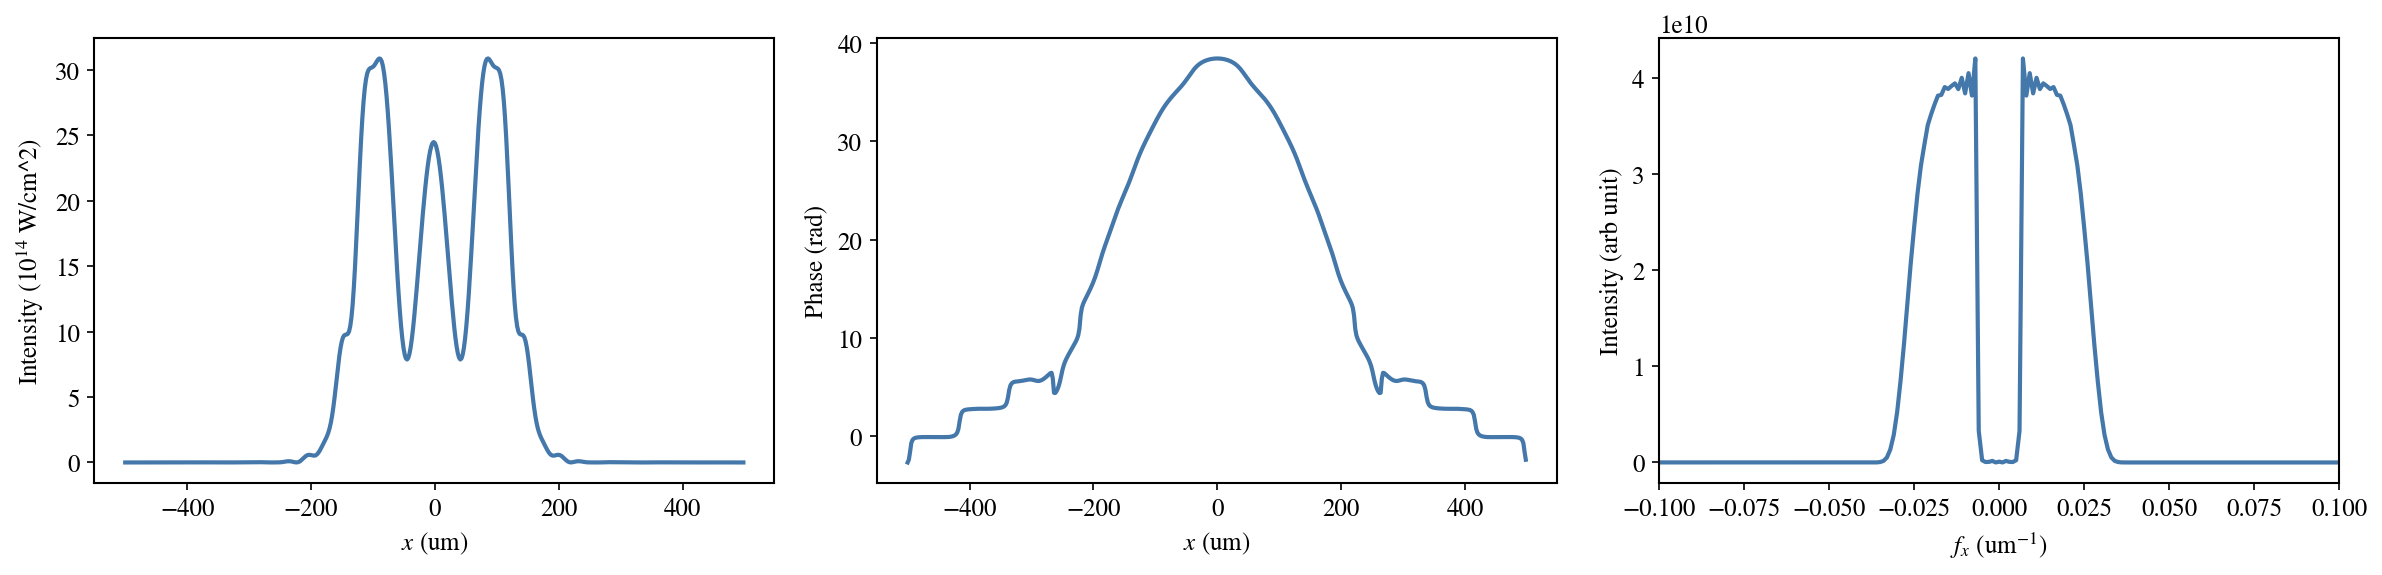

In [11]:
plot_current_field_pulse(pulse, 36, flim=[-0.1, 0.1])

In [12]:
print('Initial pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
hydrogen = plasma.Plasma(plasmaParams)

# Initialize gas density
ne = np.zeros((Nx, Nx, Nz), dtype='double')
hydrogen.initialize_plasma(n/1e17, ne)

interactions.pulse_plasma_energy(pulse, hydrogen, temp, n2)
print('Final pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
e = np.zeros((Nz, Nx), dtype='complex128')
ne = np.zeros((Nz, Nx))
for i in range(0, Nz-1):
    ne[i, :] = hydrogen.load_plasma_density(i)[0]
for i in range(Nz):
    e[i, :] = pulse.load_field(i)[0][int(pulseParams['Nt']/2), :]
I = ionization.intensity_from_field(e)
ne = ne*1e17

Initial pulse energy 120.17mJ
Final pulse energy 40.57mJ


In [13]:
np.save(path+'Final_Field.npy', pulse.e)

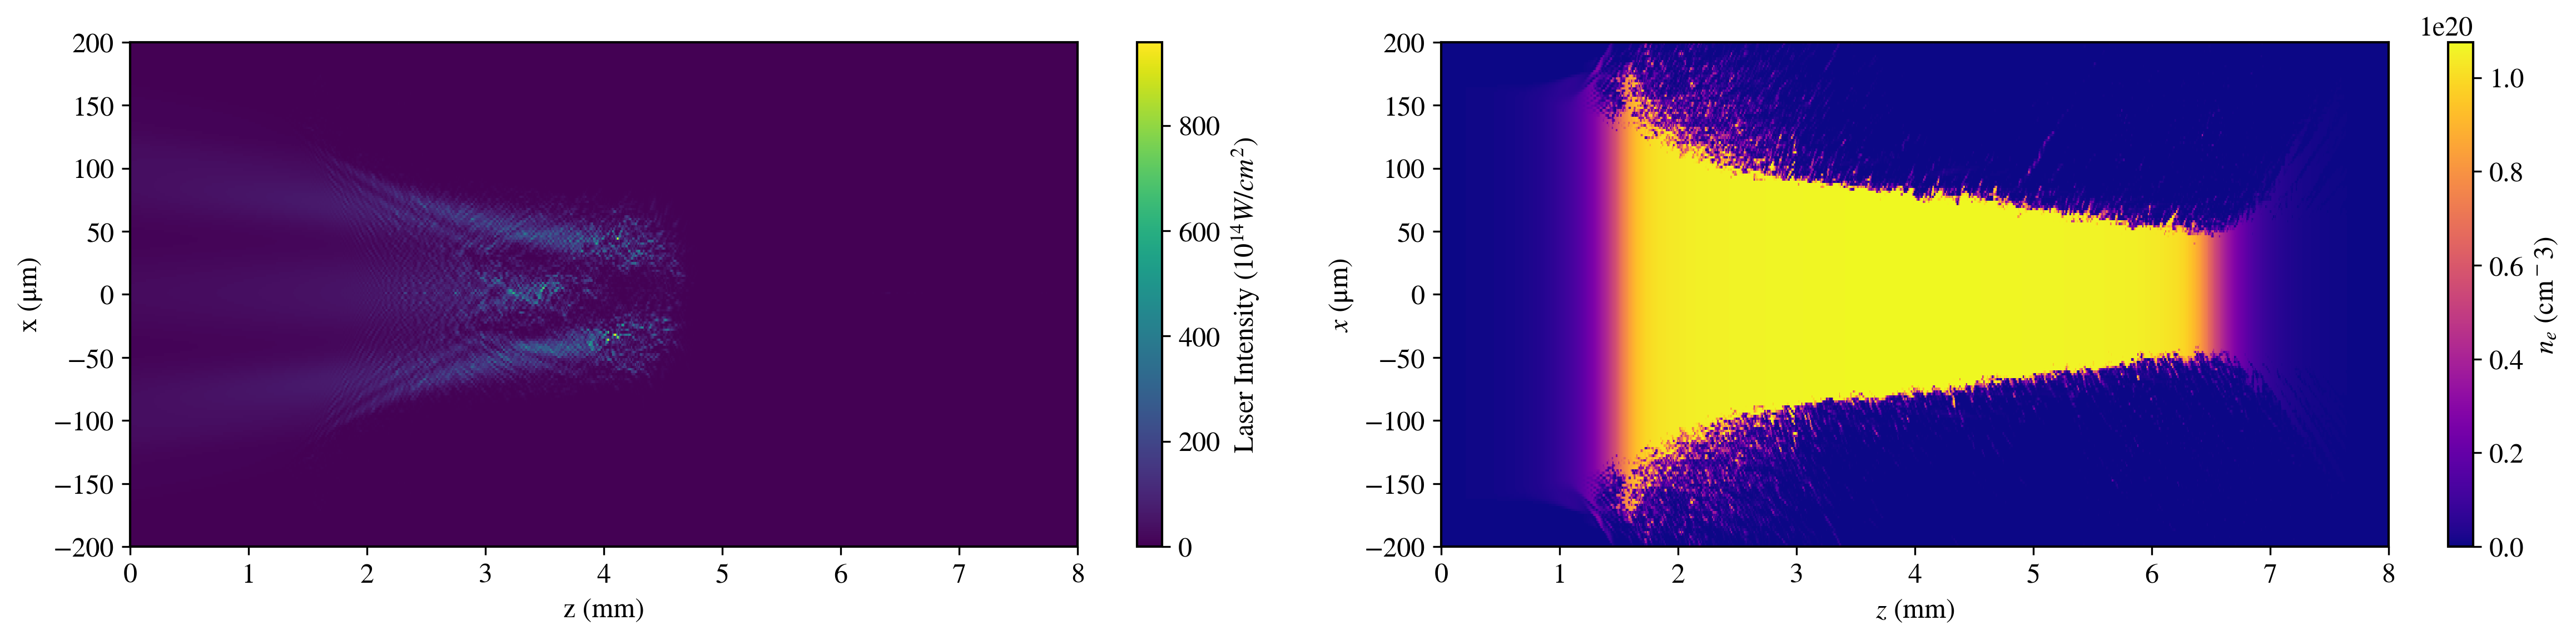

In [14]:
plot_laser_plasma(I, ne, [z[0]/1e3, z[-1]/1e3, -Xp/2, Xp/2], 'Refracted_Pulse')

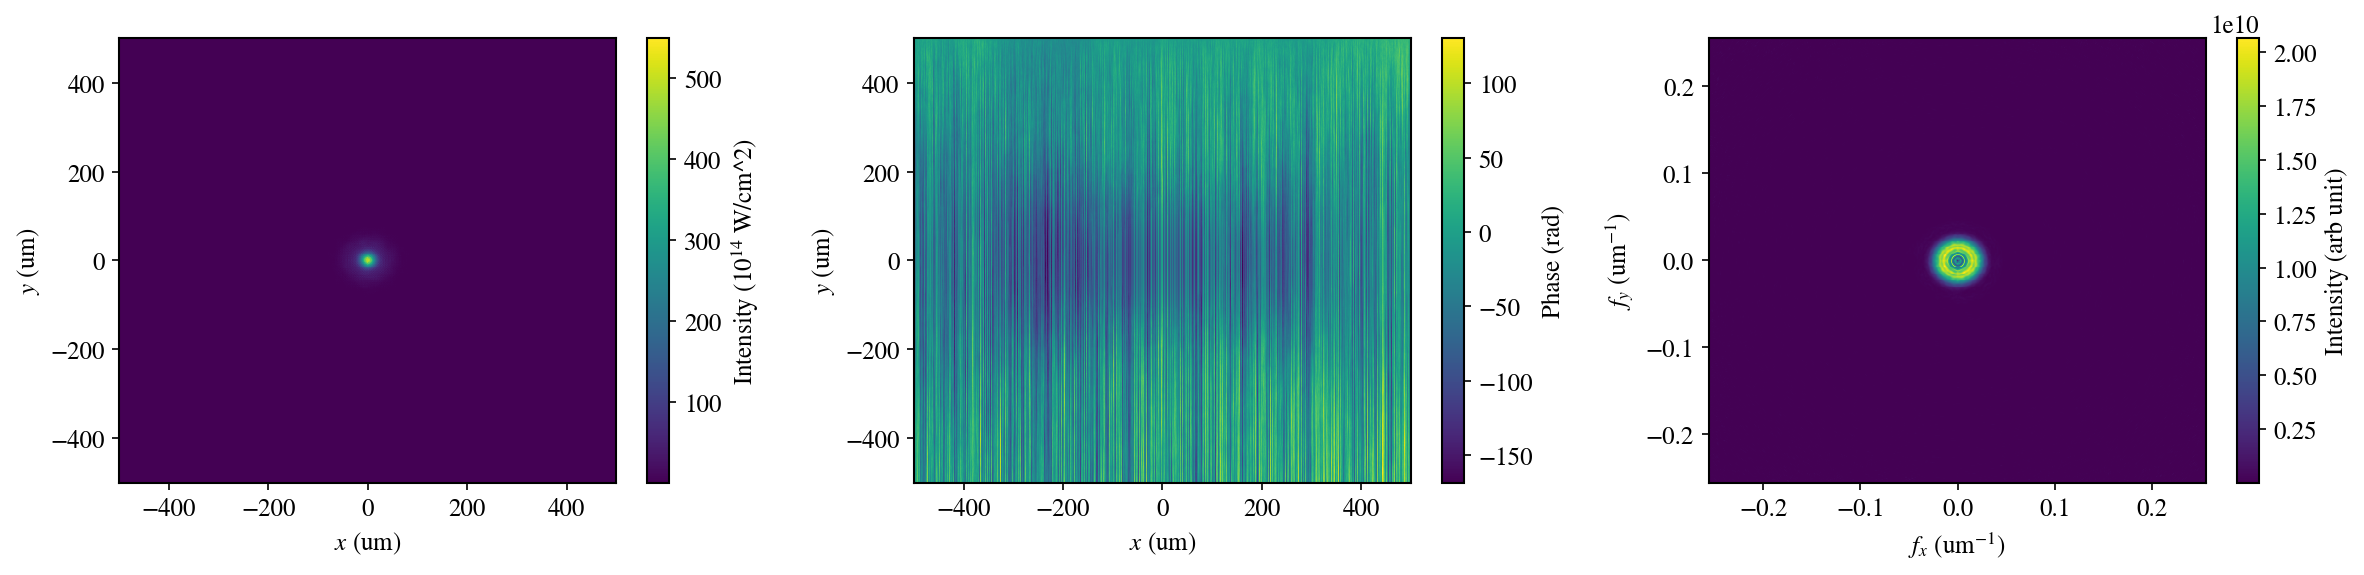

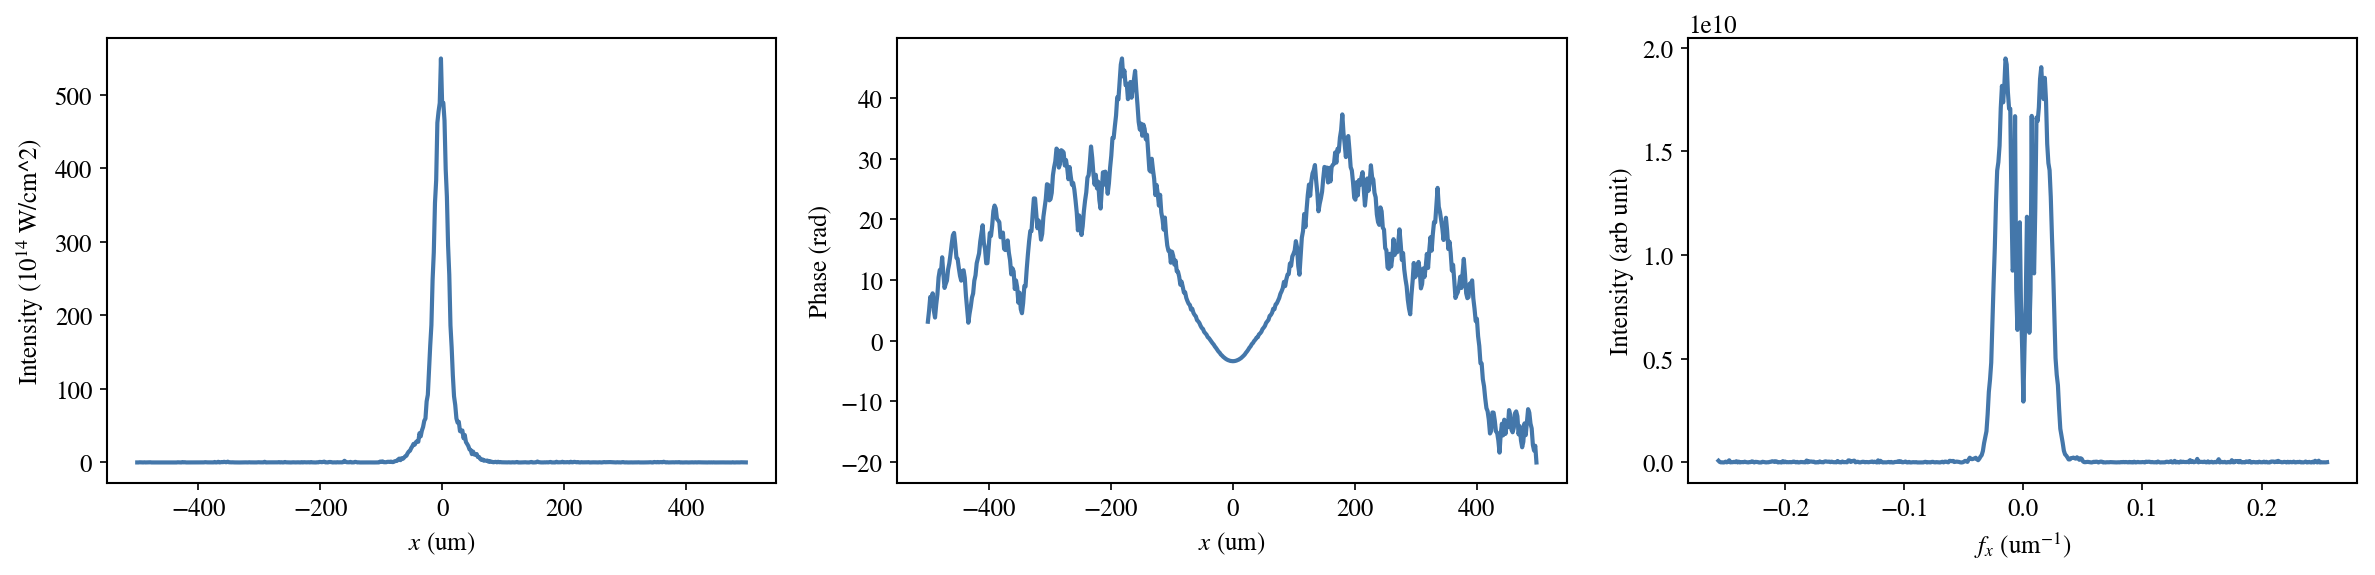

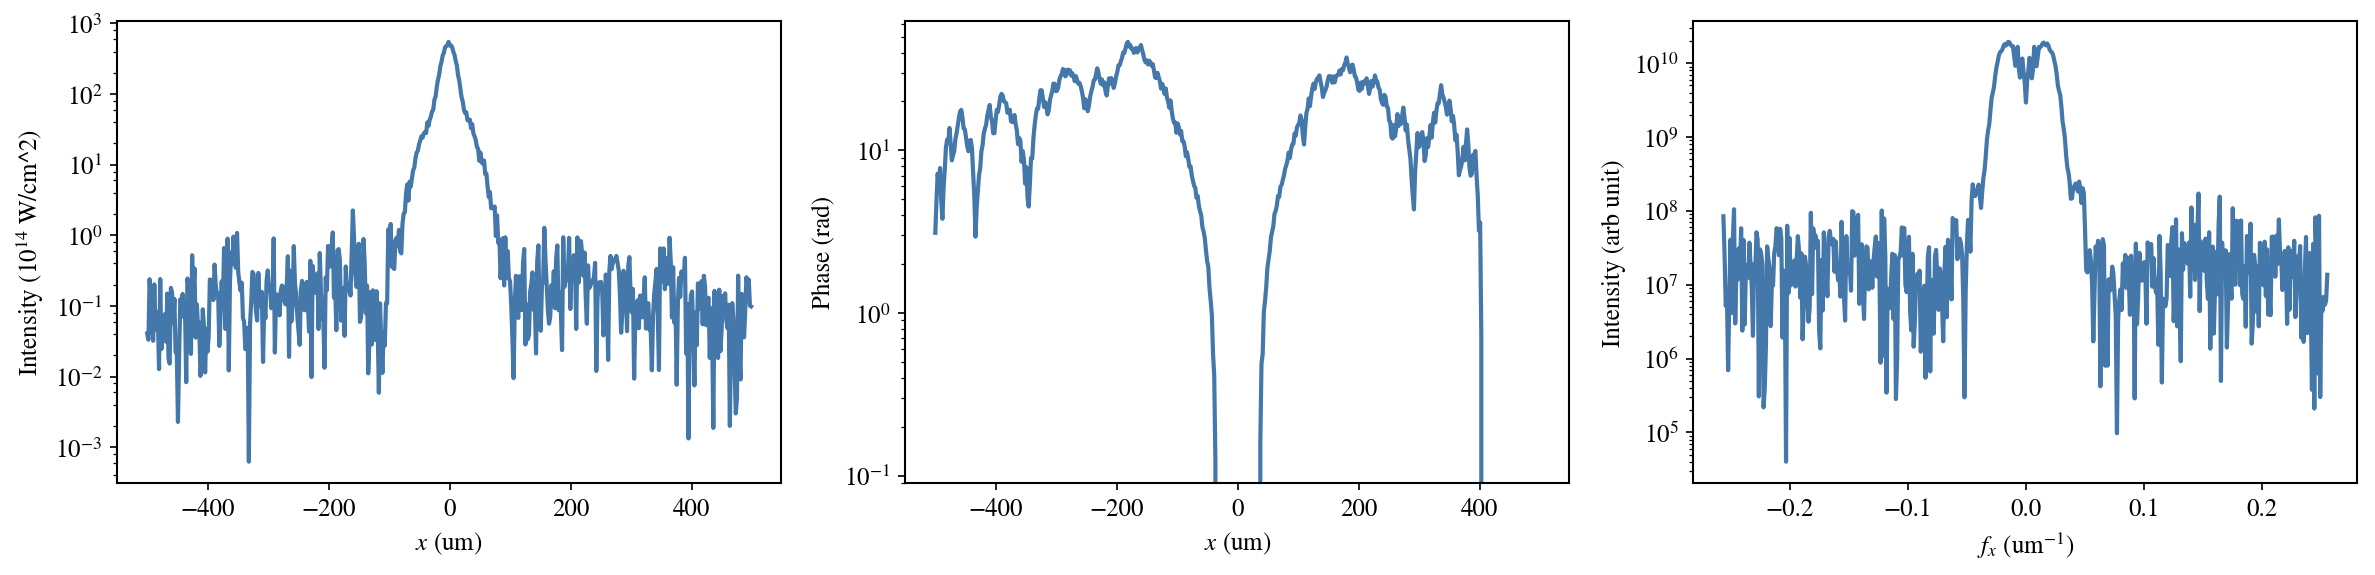

In [15]:
plot_current_field_pulse(pulse, 42, log=True)

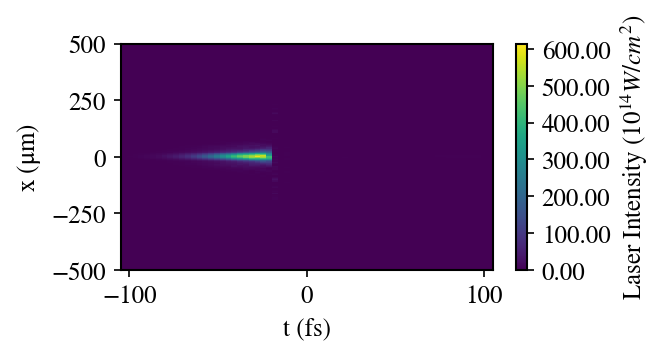

In [16]:
design.plot_pulse(pulse, Nz-1)

In [45]:
e = np.load(path+'Final_Field.npy')
pulseParams['name'] = 'Load_Field'
pulse2 = laserpulse.Pulse(pulseParams)
pulse2.initialize_field(e)

In [46]:
n = 6
w0 = 100
x2 = np.reshape(pulse2.x, (pulse2.Nx, 1))**2
y2 = np.reshape(pulse2.y, (1, pulse2.Ny))**2
r = np.sqrt(x2 + y2)
multi = np.exp(-(r/w0)**n)
pulse2.e *= multi

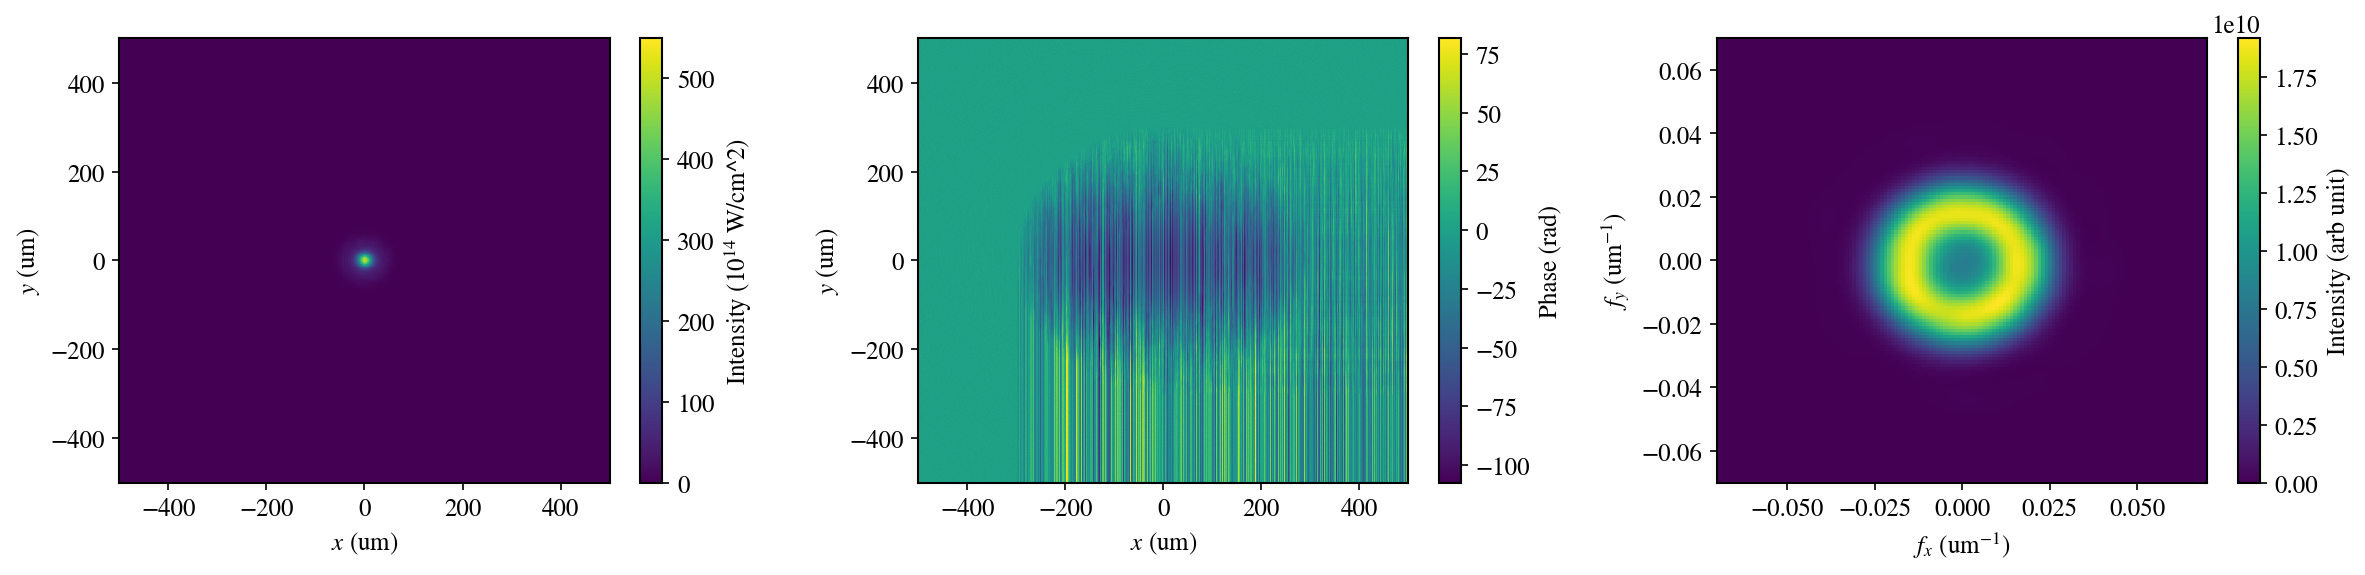

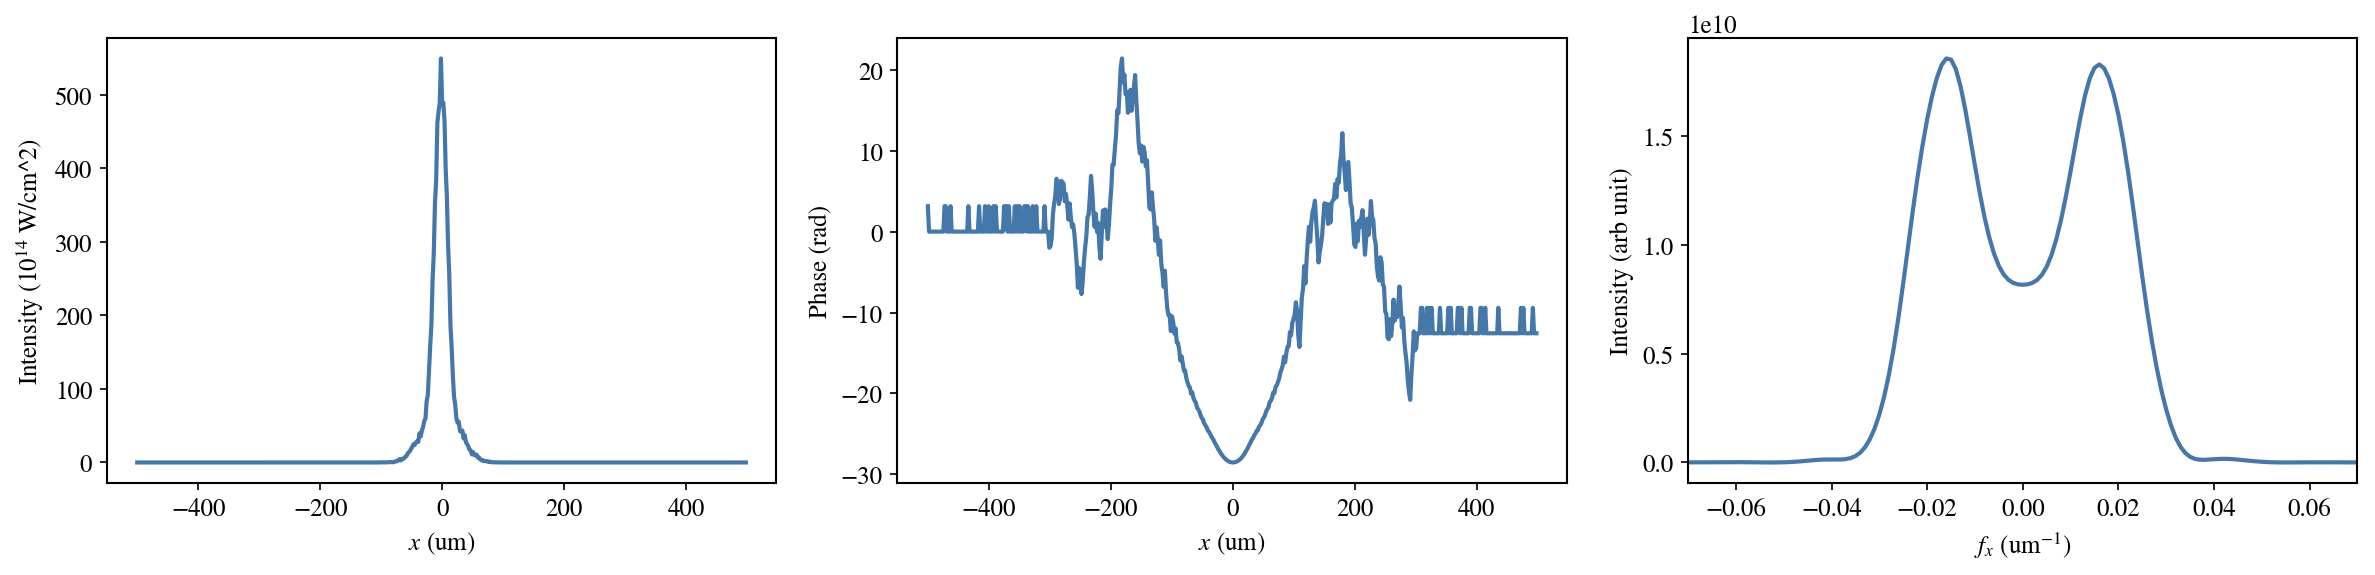

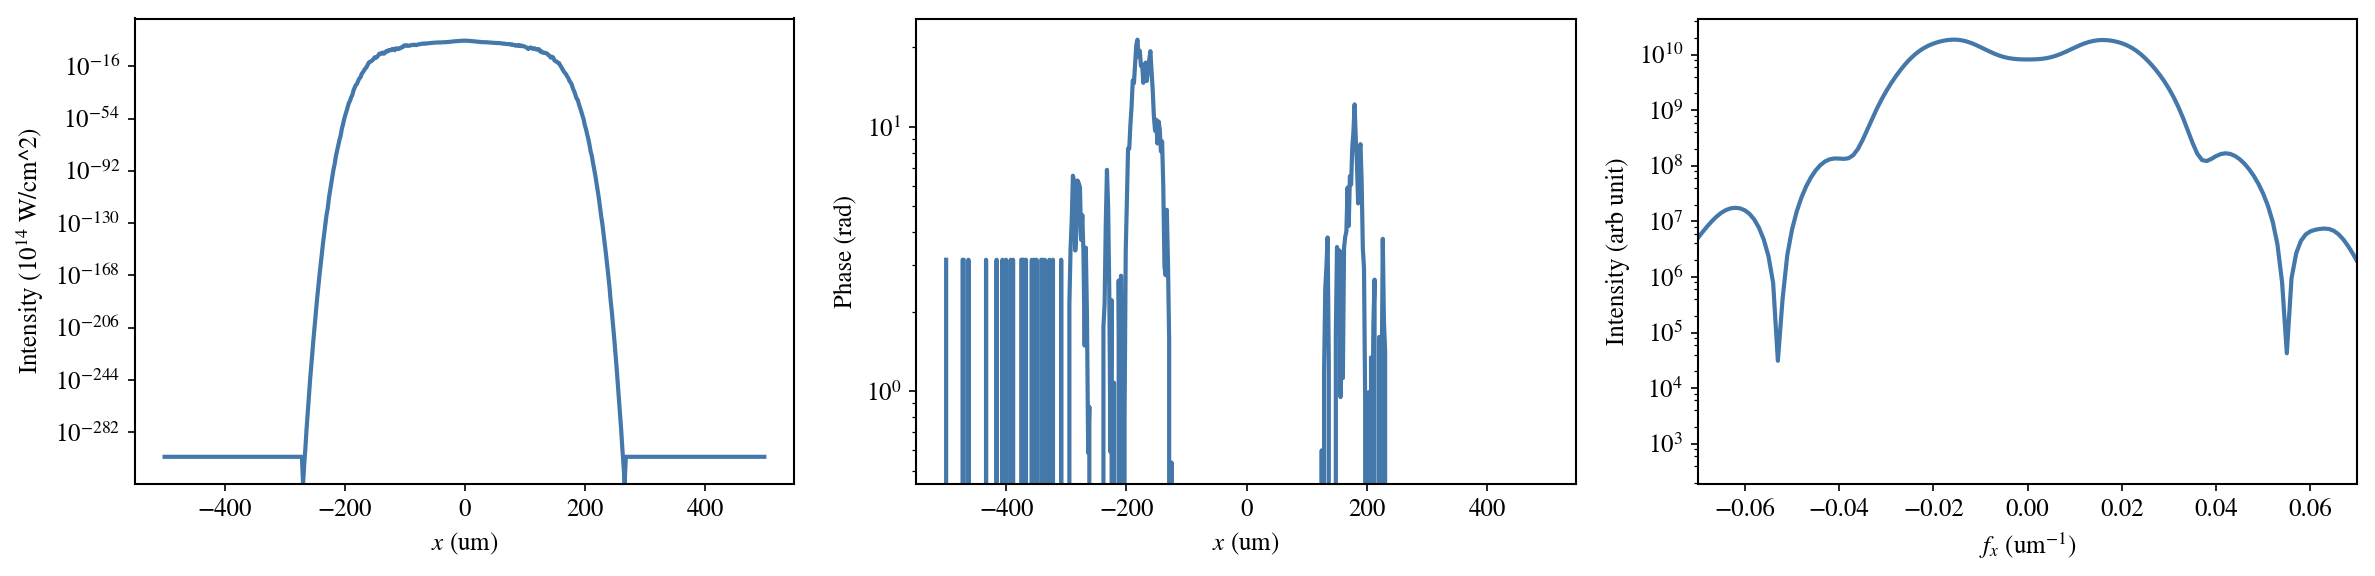

In [47]:
plot_current_field_pulse(pulse2, 42, flim=[-0.07, 0.07], log=True)

In [48]:
Nx_out = 2**11
X_out = 8e3
Nz_out = 4
Z_out = 0.001e3
I_out, pulse_out0 = design.propagate_down_beampipe(pulse2, [Z_out], [X_out], X_out, Nx_out, Nz_out, ret_pulse=True)

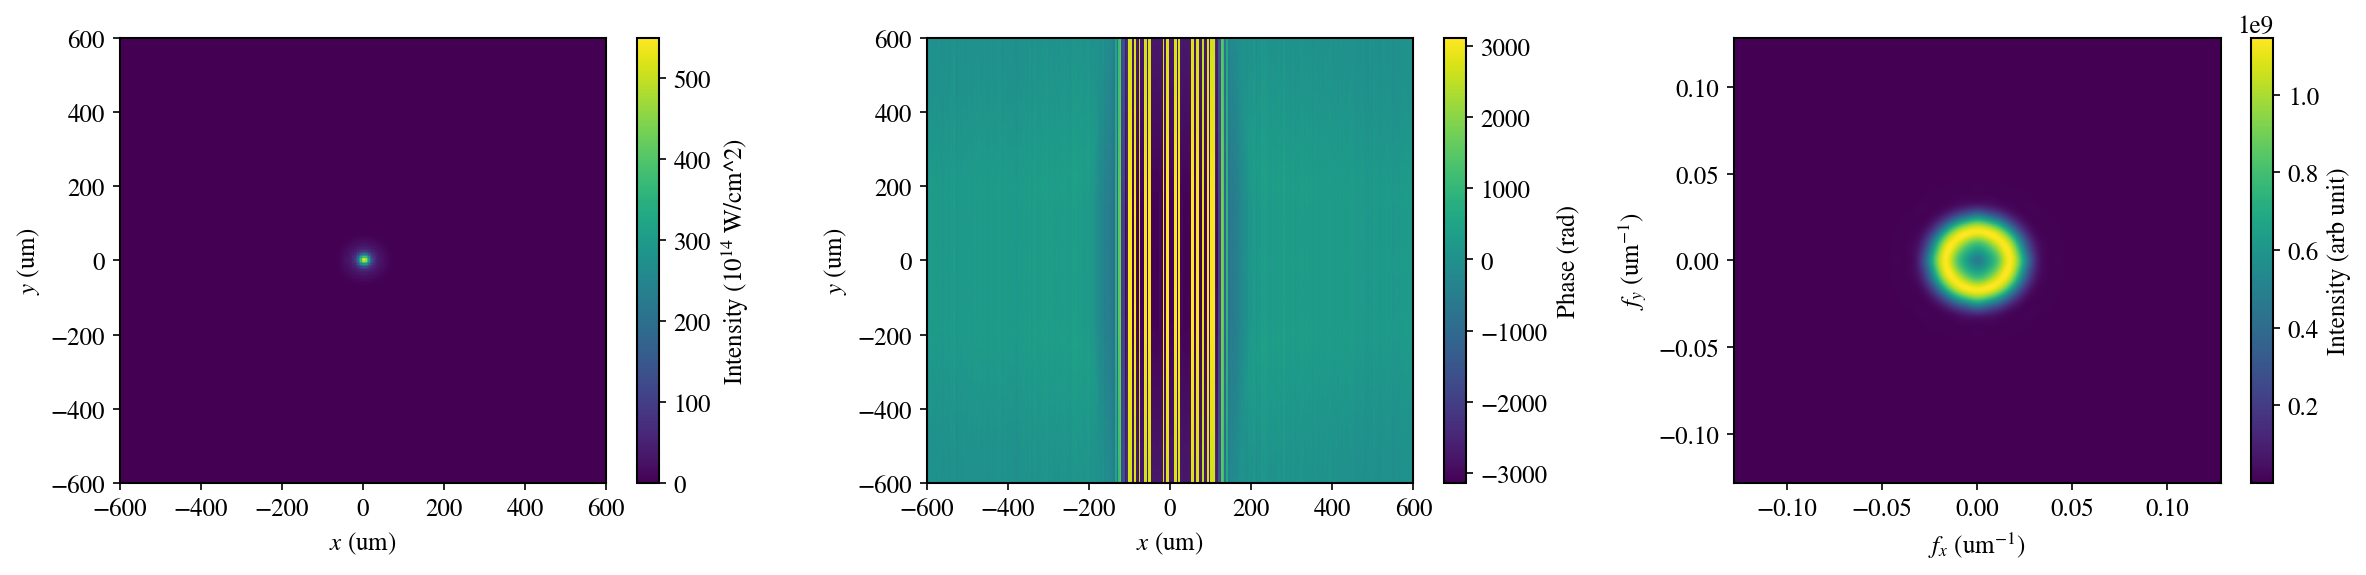

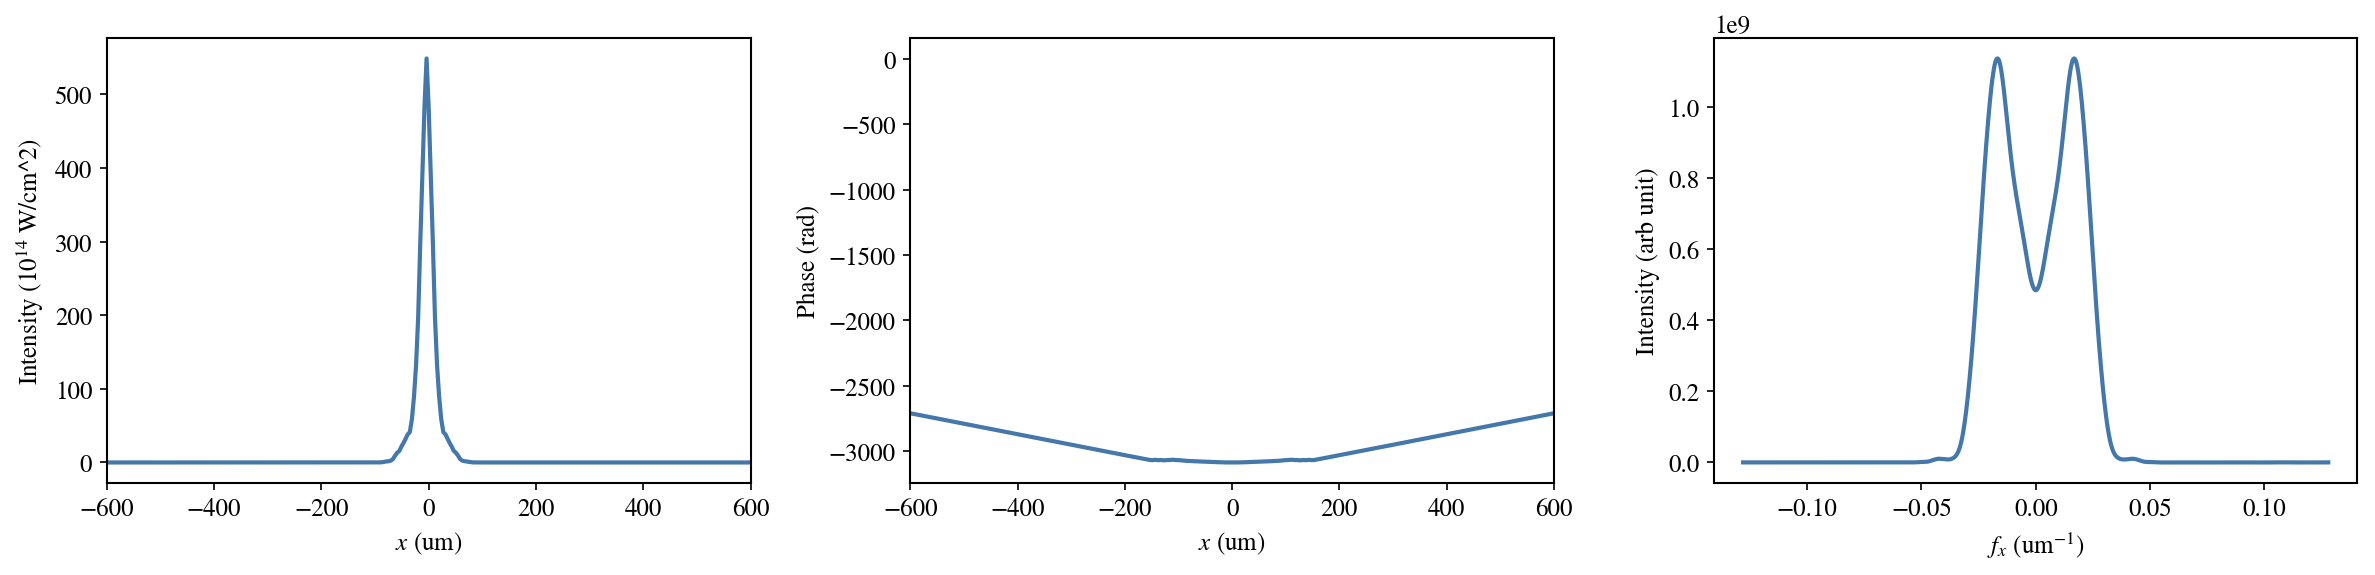

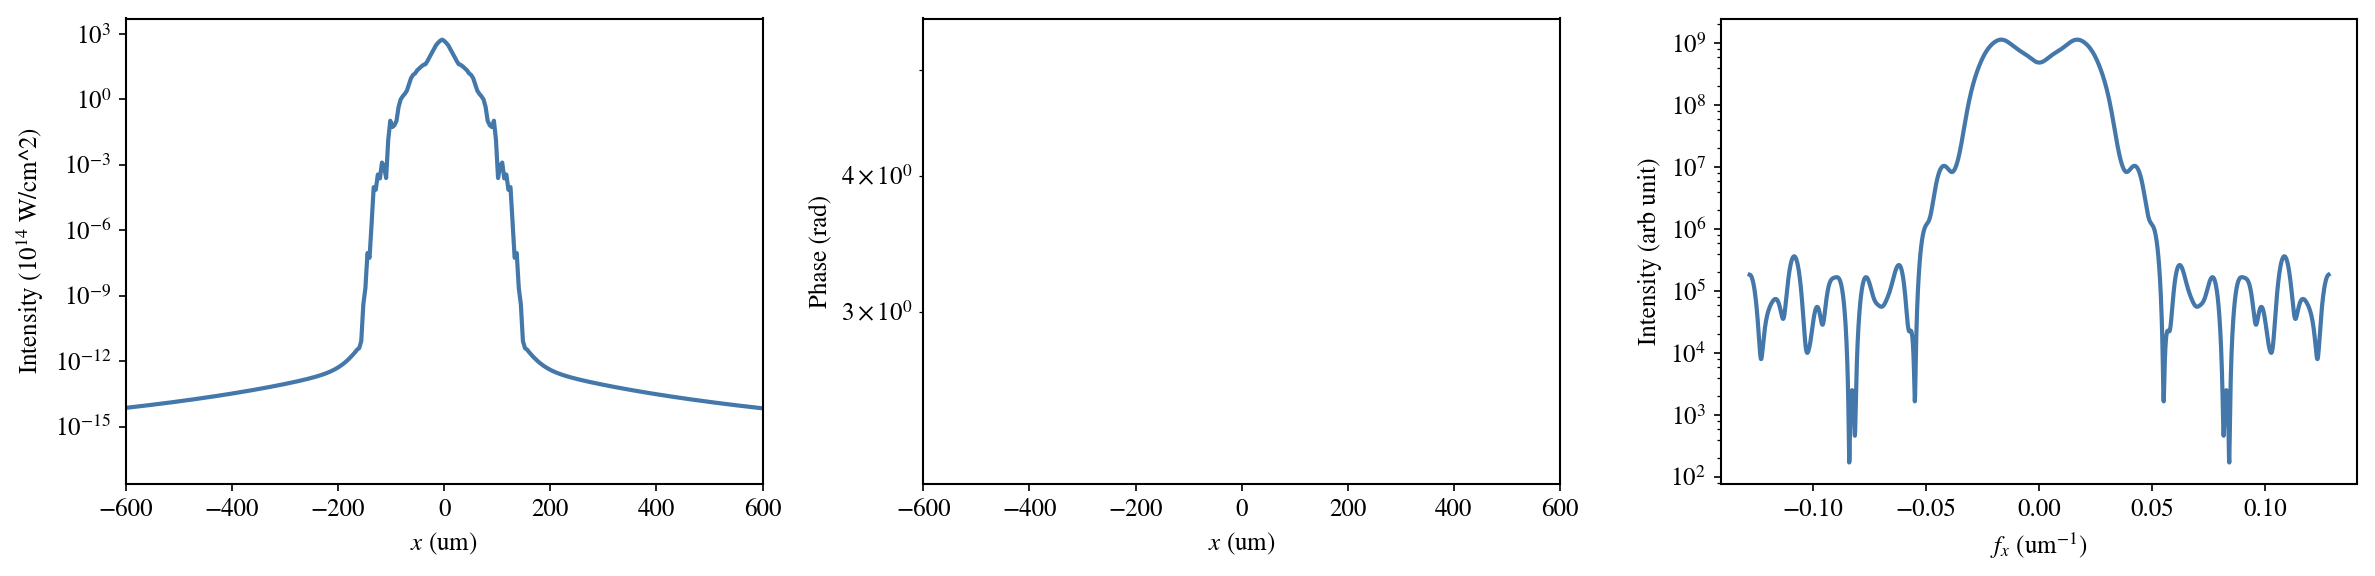

In [49]:
plot_current_field_pulse(pulse_out0, 42, xlim=[-600, 600], log=True)

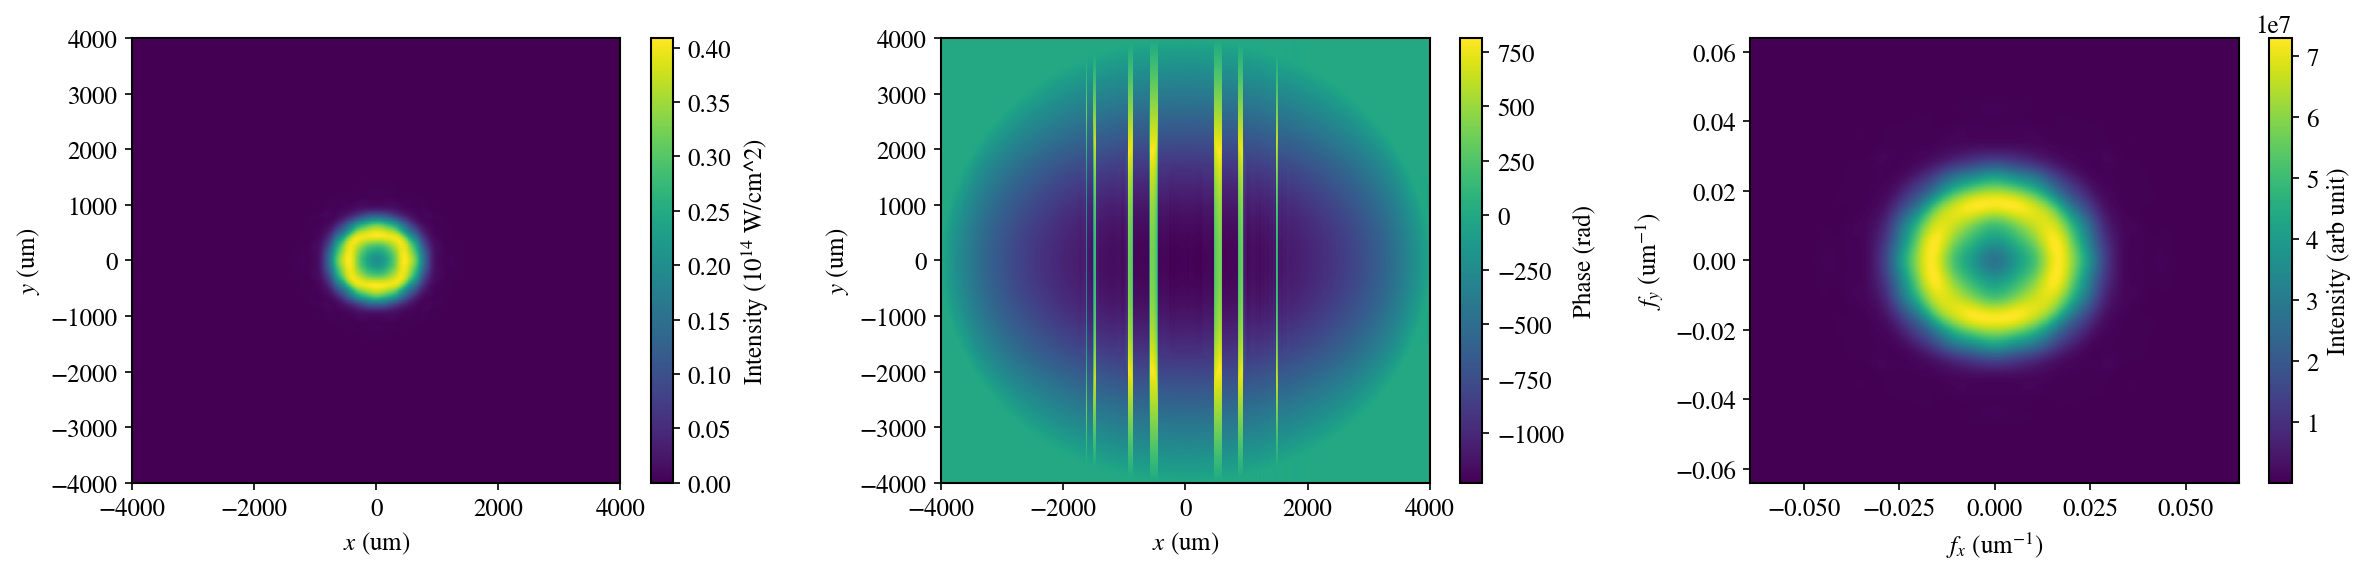

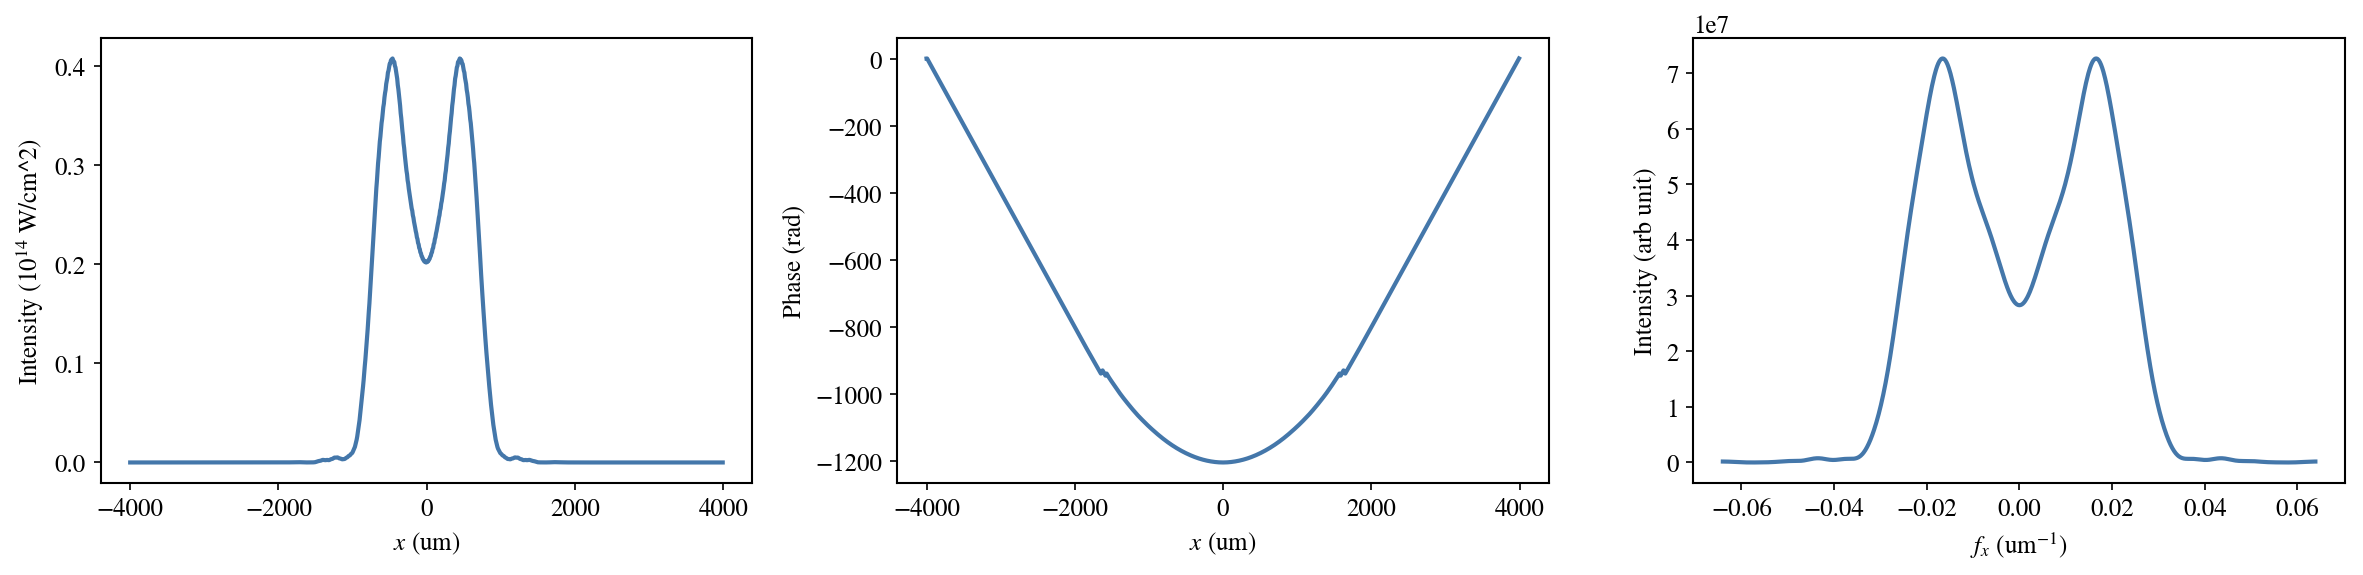

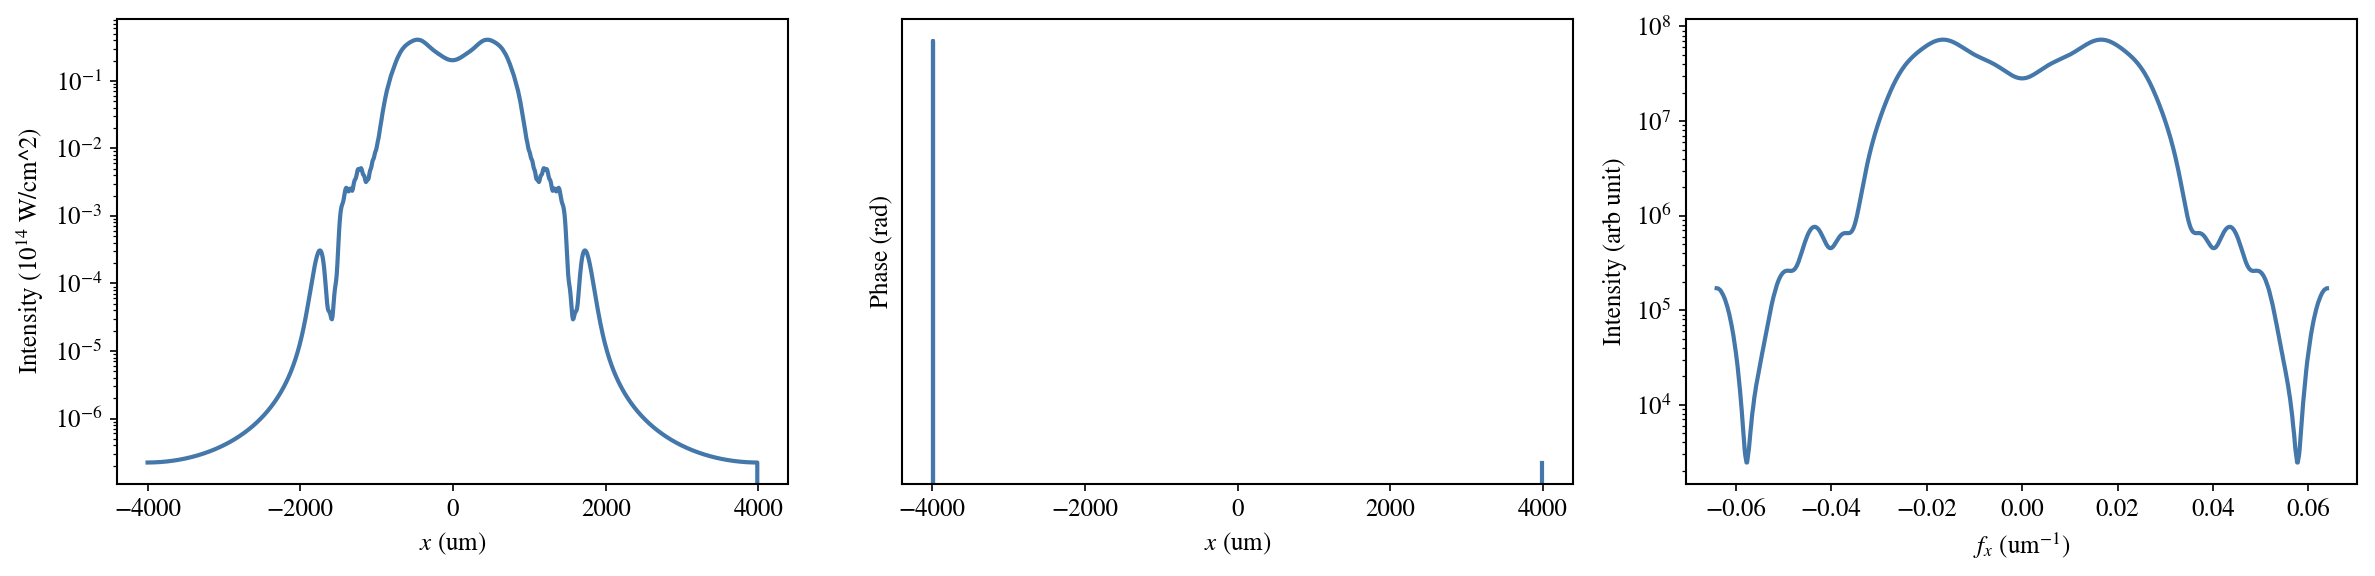

In [50]:
Nx_out = 2**10
X_out = 8e3
Nz_out = 25
z_start = 1e3
Z_out = 35e3
I_out, pulse_out = design.propagate_down_beampipe(pulse2, [Z_out], [X_out], X_out, Nx_out, Nz_out, ret_pulse=True)
Im[M] = prep_ma(Z, X, Nz_out, Z_out, f+z_start, X_out, Nx_out, I_out)
start = f + z_start + Z_out
plot_current_field_pulse(pulse_out, 42, log=True)

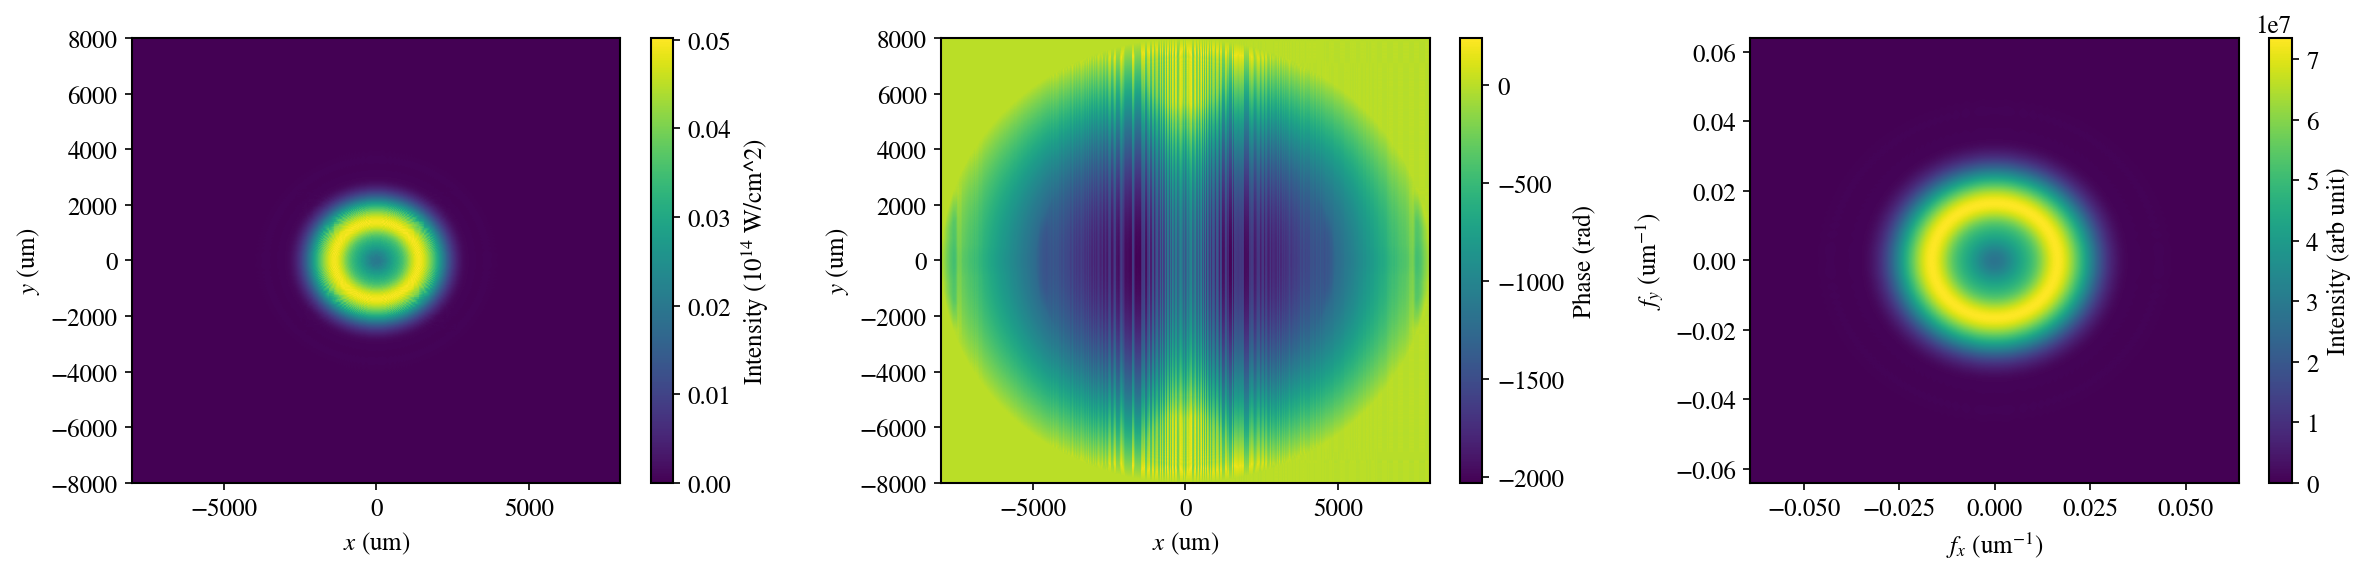

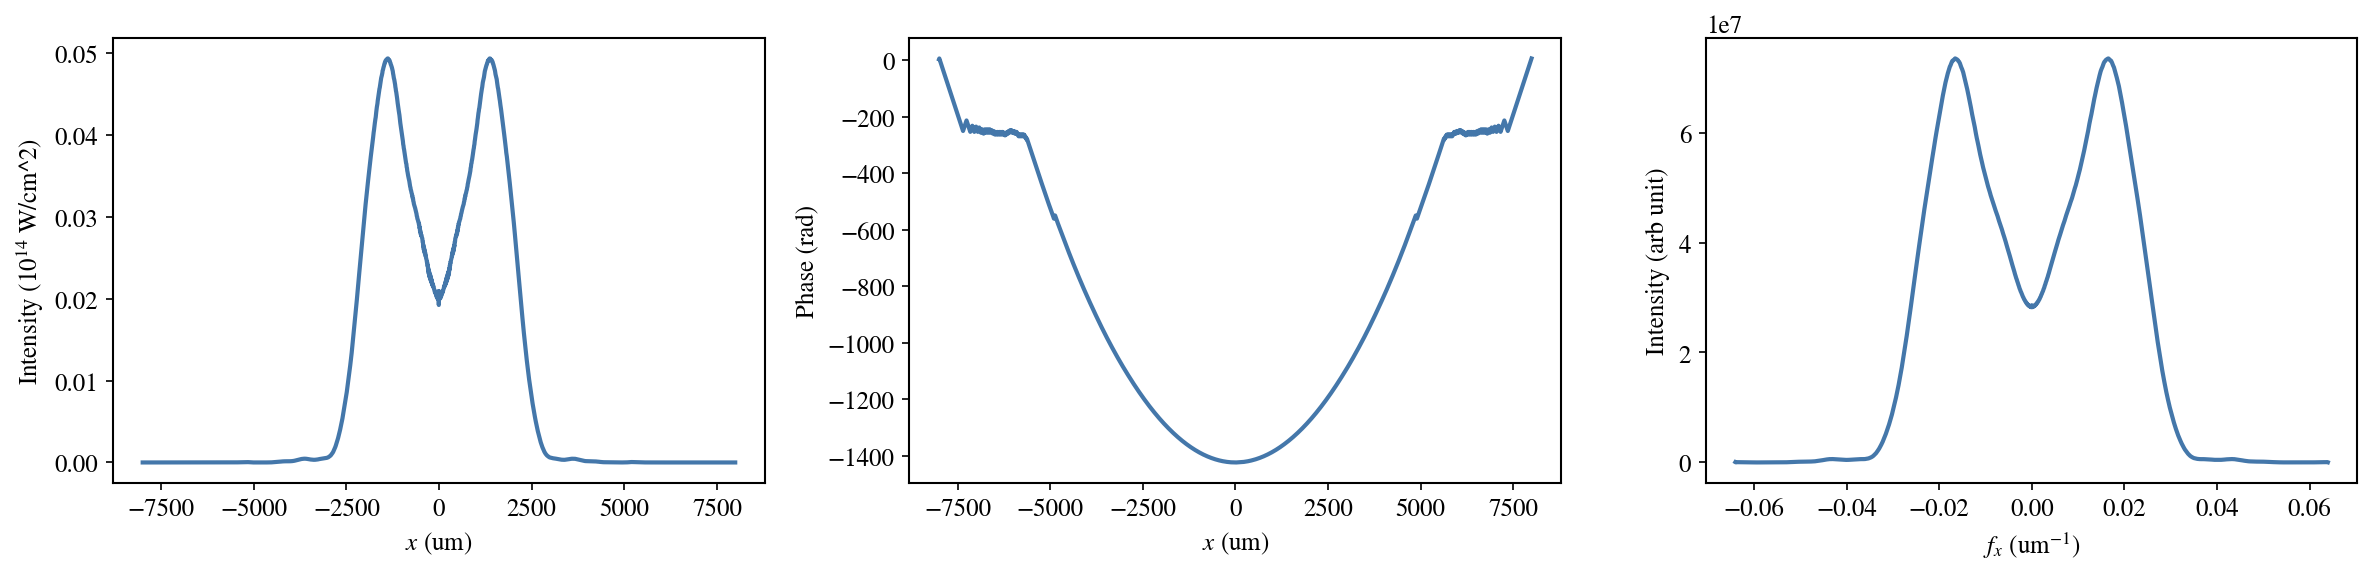

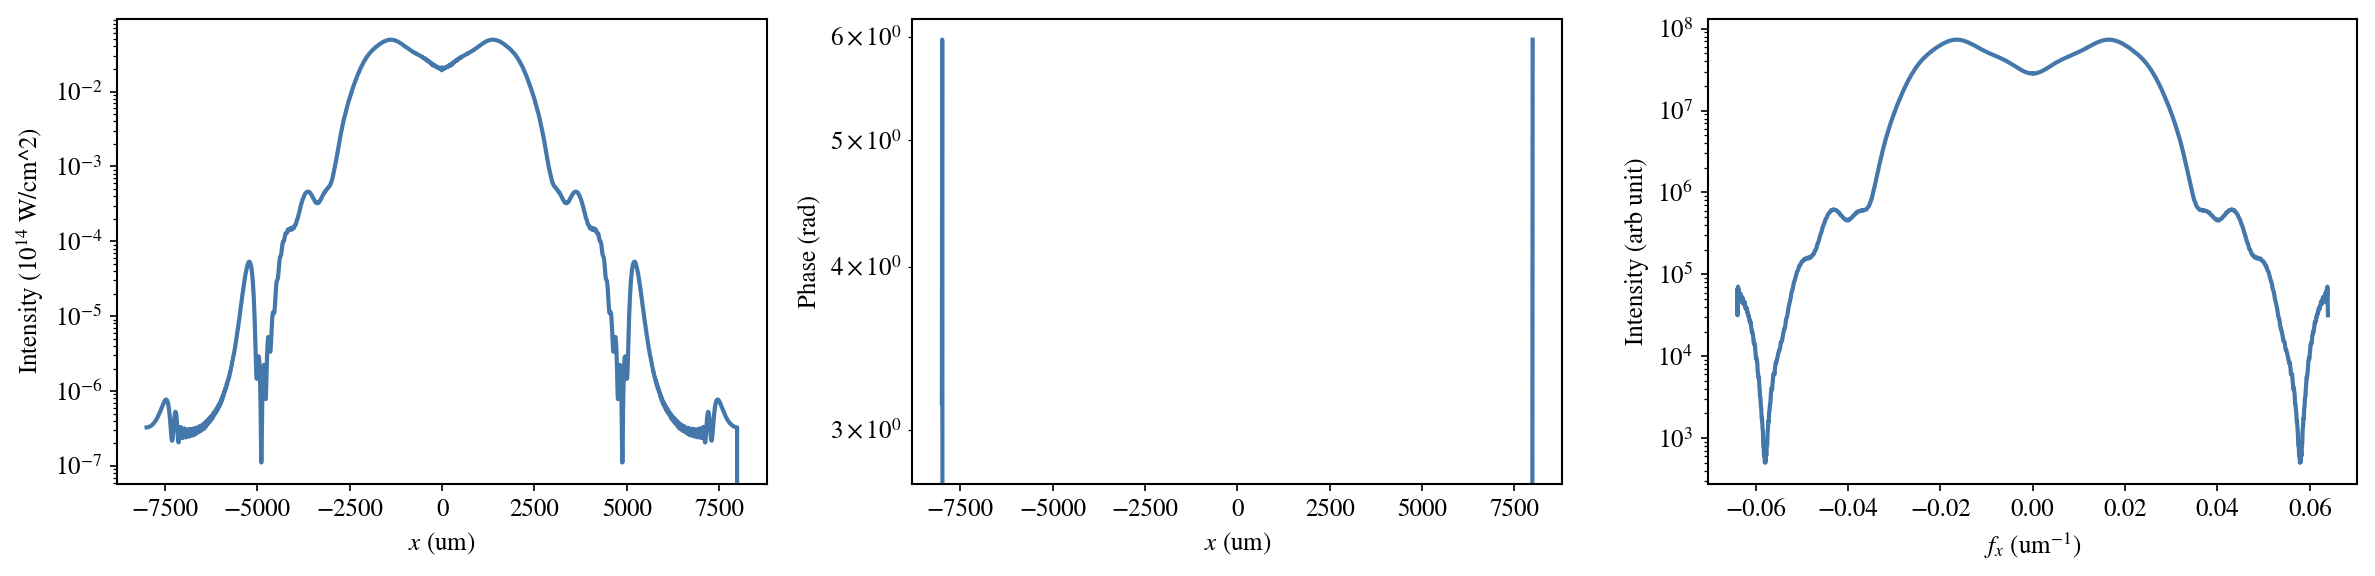

In [51]:
Nx_out = 2**11
X_out = 16e3
Nz_out = 50
Z_out = 70e3
I_out, pulse_out = design.propagate_down_beampipe(pulse_out, [Z_out], [X_out], X_out, Nx_out, Nz_out, ret_pulse=True)
Im[M+1] = prep_ma(Z, X, Nz_out, Z_out, start, X_out, Nx_out, I_out)
start1 = start + Z_out
plot_current_field_pulse(pulse_out, 42, log=True)

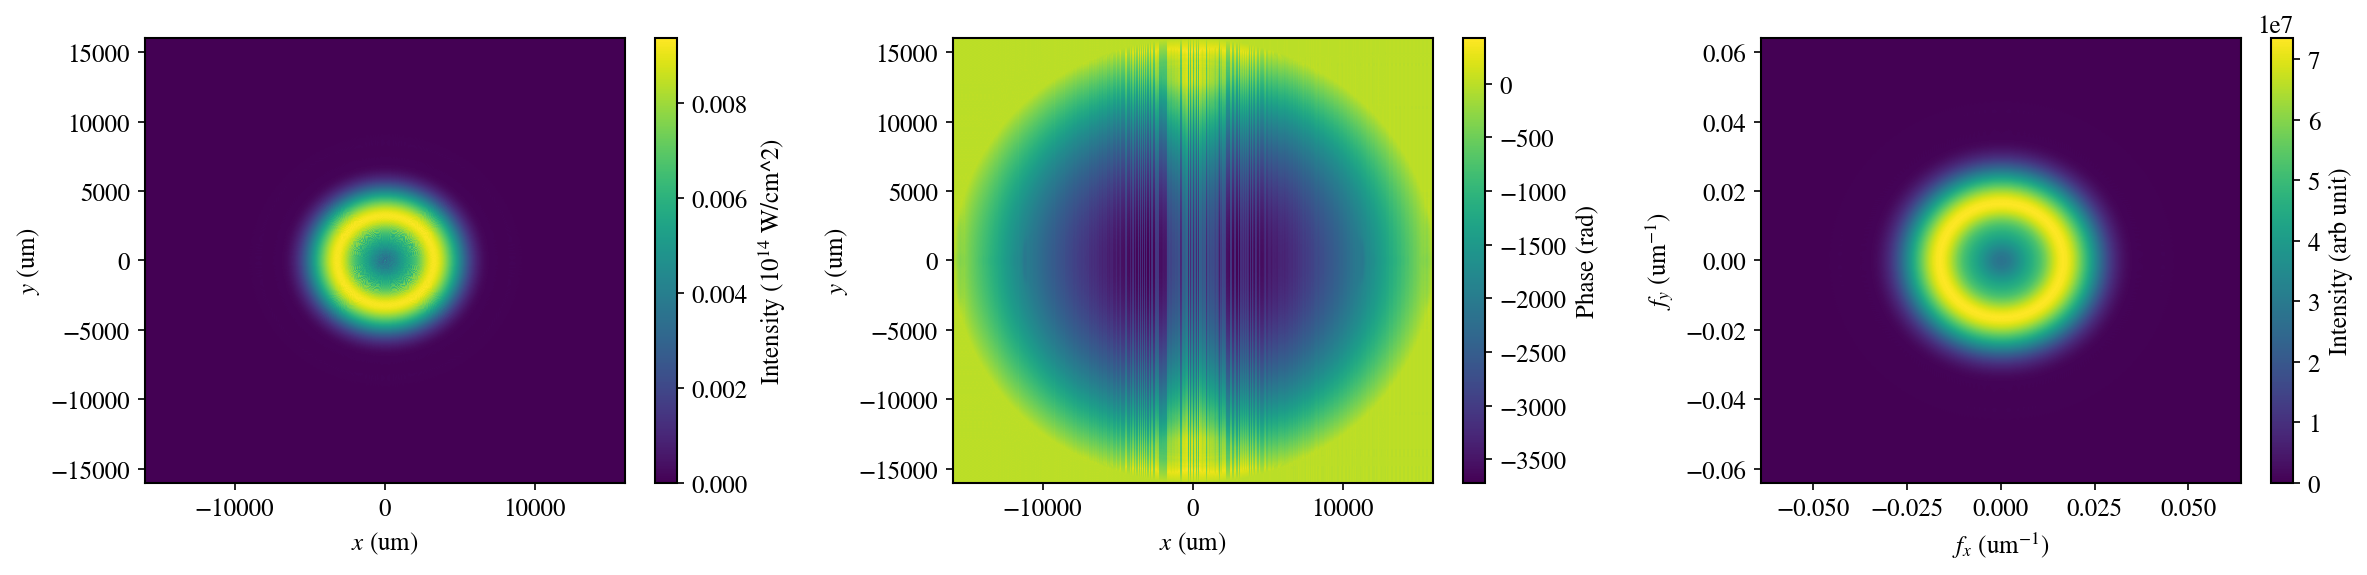

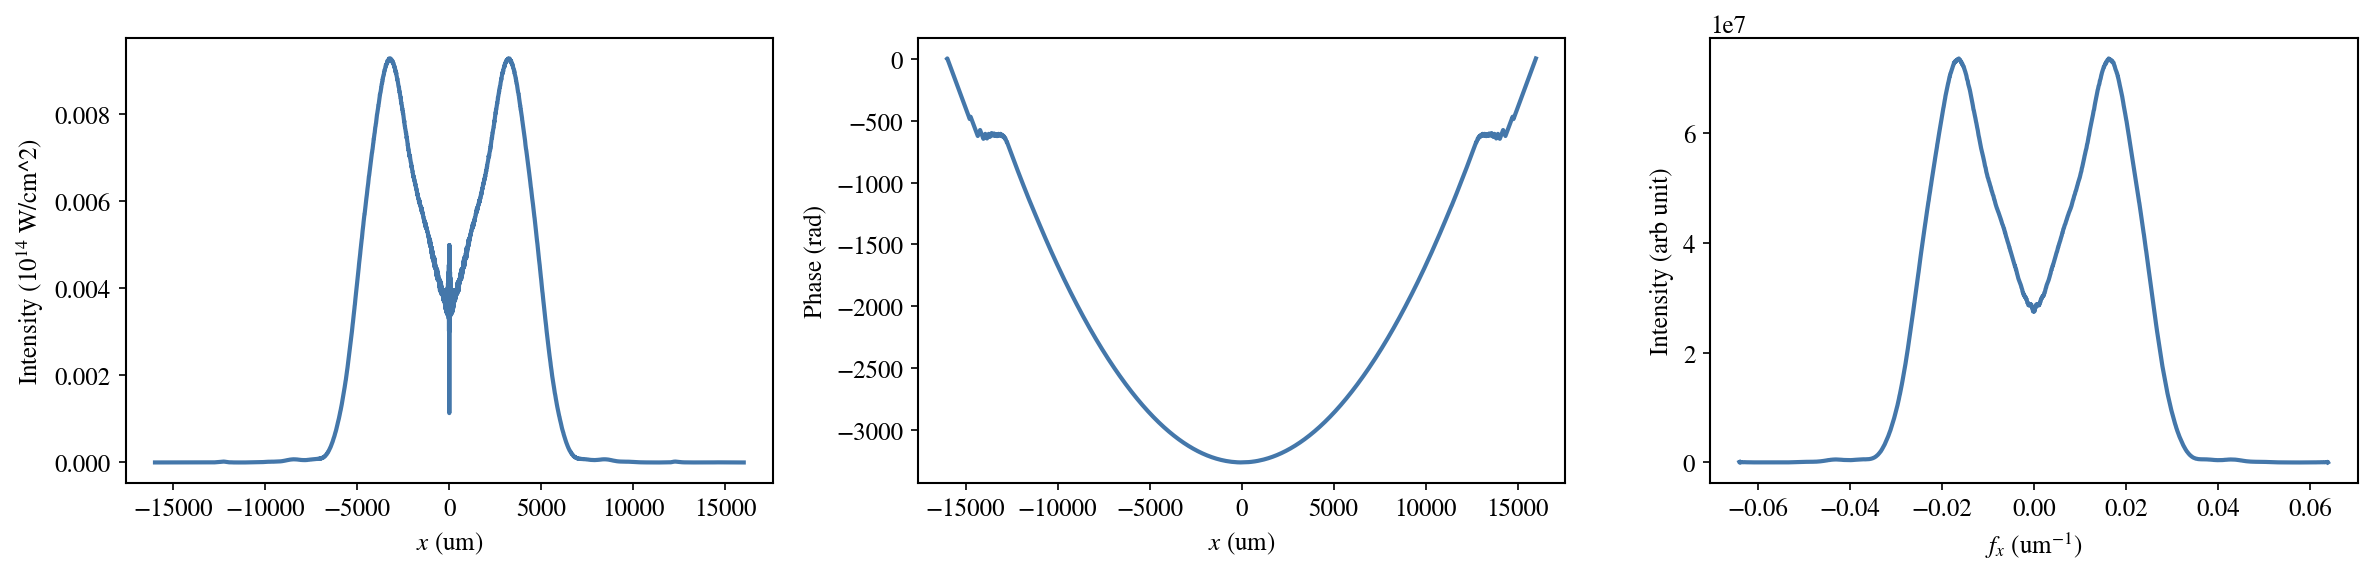

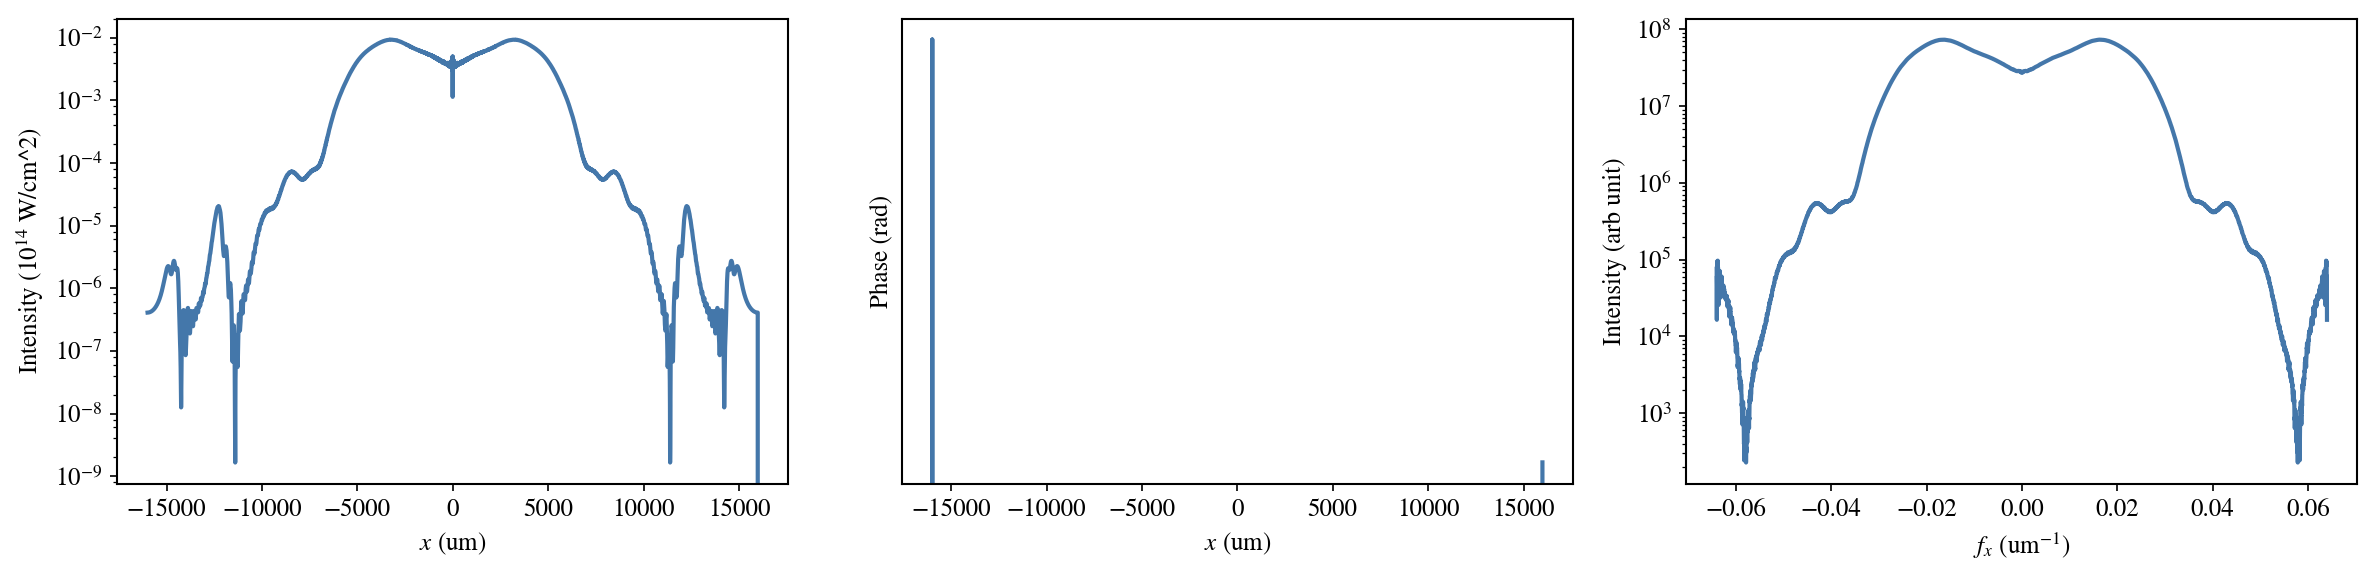

In [52]:
Nx_out = 2**12
X_out = 32e3
Nz_out = 100
Z_out = 140e3
I_out, pulse_out = design.propagate_down_beampipe(pulse_out, [Z_out], [X_out], X_out, Nx_out, Nz_out, ret_pulse=True)
Im[M+2] = prep_ma(Z, X, Nz_out, Z_out, start1, X_out, Nx_out, I_out)
start2 = start1 + Z_out
plot_current_field_pulse(pulse_out, 42, log=True)

In [84]:
def calc_far_field(pulse):
    fx, fy = pulse.get_f()
    fx = fftshift(fx)
    fy = fftshift(fy)
    If = np.zeros((pulse.Nt, pulse.Nx, pulse.Ny))
    for i in range(pulse.Nt):
        If[i] = abs(fftshift(pulse.fft(pulse.e[i])))**2
    If = np.amax(If, axis=0)
    If = interp1d(fx, If[:, int(pulse.Ny/2)], kind='cubic', bounds_error=False, fill_value=0.0)
    return If
If = calc_far_field(pulse_out0)
multi = 5.5e12

In [85]:
# Define beampipe locations and widths
z_B1 = 1384
w_B1 = 41.1
z_B2 = 1584.4
w_B2 = 31.8

In [86]:
Z_out = z_B1*1e3-start2
Nx_out = 2**10
X_out = 60e3
Nz_out = 300
z = np.linspace(start2, start2+Z_out, Nz_out)
x = np.linspace(-X_out/2, X_out/2, Nx_out)
I_out = np.zeros((Nz_out, Nx_out))
for i in range(Nz_out):
    fx = x/(lam*(z[i]-f))
    I_out[i, :] = If(fx)/(z[i]-f)**2/pulse_out0.Nx**4/lam**2
I_out = pulse_out.prep_data(I_out)
Im[M+3] = prep_ma(Z, X, Nz_out, Z_out, start2, X_out, Nx_out, I_out*multi)
start3 = start2+Z_out

(4096, 4096)


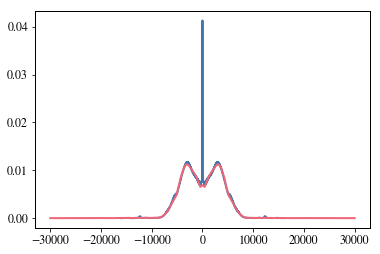

In [87]:
I = np.amax(pulse_out.intensity_from_field(pulse_out.e), axis=0)
print(np.shape(I))
plt.plot(pulse_out.x, I[:, int(pulse_out.Ny/2)])
plt.plot(x, I_out[:, 0]*multi)
plt.show()

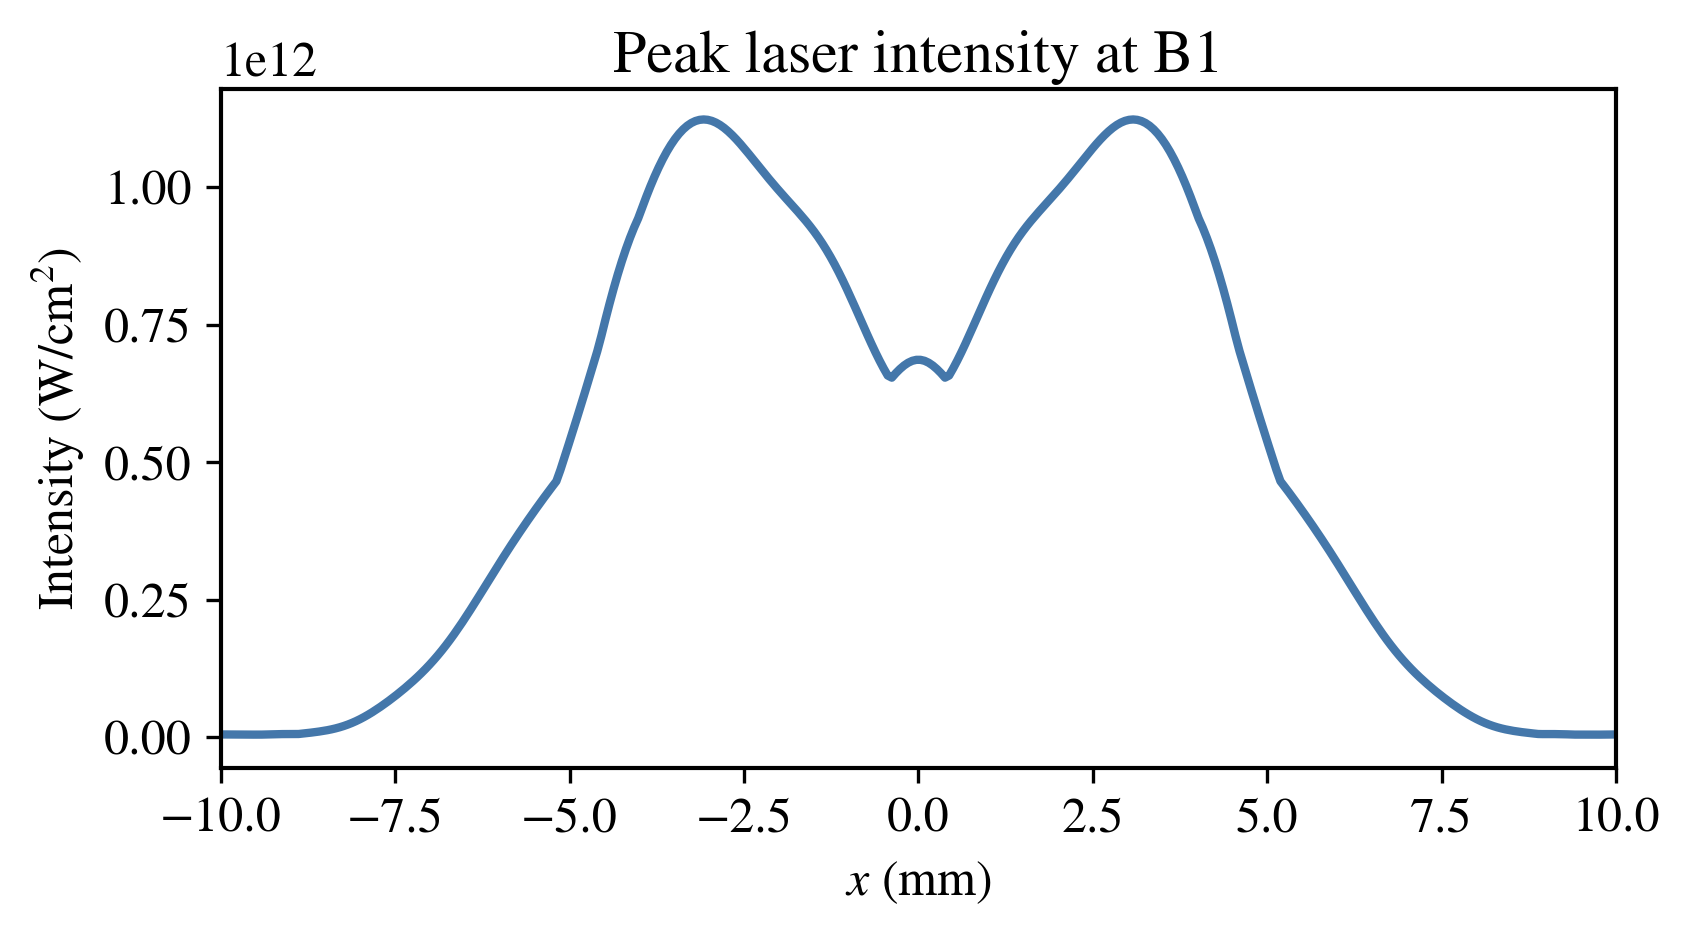

In [88]:
plt.figure(figsize=(6, 3), dpi=300)
plt.plot(x/1e3, I_out[:, 0]*multi*1e14)
plt.xlabel(r'$x$ (mm)')
plt.ylabel(r'Intensity ($\mathrm{W/cm^2}$)')
plt.title('Peak laser intensity at B1')
plt.xlim(-10, 10)
plt.show()

/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


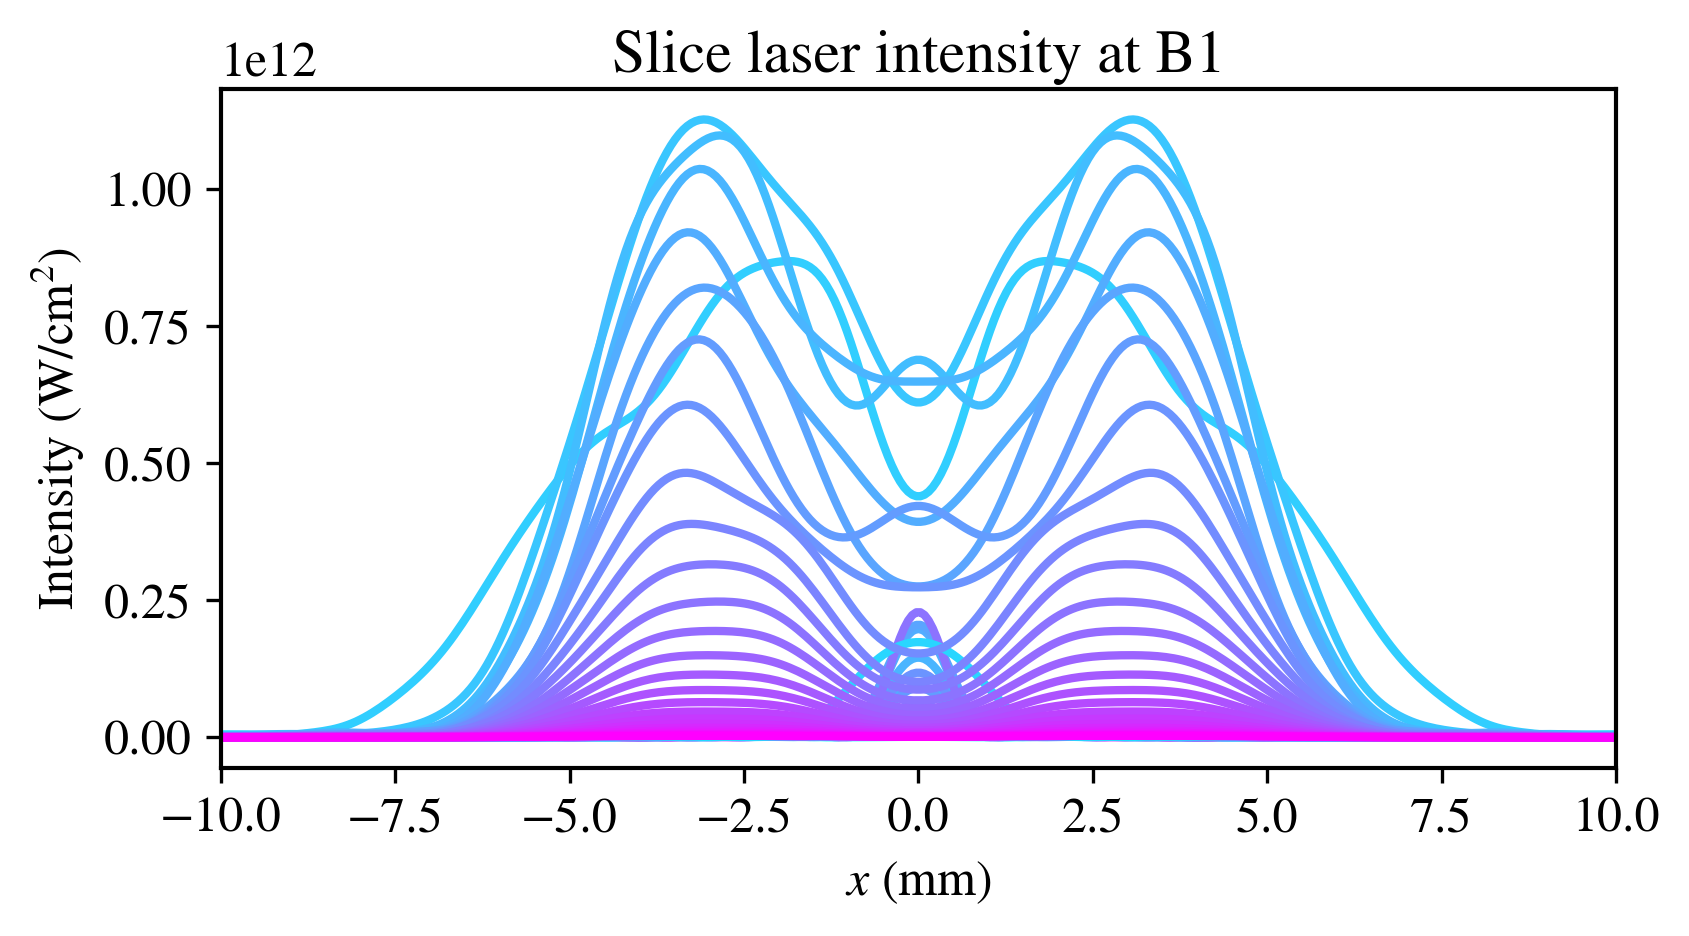

In [95]:
def calc_far_field_slice(pulse, int_t):
    fx, fy = pulse.get_f()
    fx = fftshift(fx)
    fy = fftshift(fy)
    If = np.zeros((pulse.Nx, pulse.Ny))
    If = abs(fftshift(pulse.fft(pulse.e[int_t])))**2
    If = interp1d(fx, If[:, int(pulse.Ny/2)], kind='cubic', bounds_error=False, fill_value=0.0)
    return If

Z_out = z_B1*1e3-start2
Nx_out = 2**10
X_out = 60e3
Nz_out = 300
z = np.linspace(start2, start2+Z_out, Nz_out)
x = np.linspace(-X_out/2, X_out/2, Nx_out)
I_out = np.zeros(Nx_out)
z = z_B1*1e3*0.90
fx = x/(lam*(z-f))

plt.figure(figsize=(6, 3), dpi=300)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, pulse_out0.Nt/2)]
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
for i in range(pulse_out0.Nt):
    If = calc_far_field_slice(pulse_out0, i)
    I_out = If(fx)/(z-f)**2/pulse_out0.Nx**4/lam**2
    
    plt.plot(x/1e3, I_out*multi*1e14)
plt.xlabel(r'$x$ (mm)')
plt.ylabel(r'Intensity ($\mathrm{W/cm^2}$)')
plt.title('Slice laser intensity at B1')
plt.xlim(-10, 10)
plt.show()

In [57]:
Z_out = z_B2*1e3-start3
Nx_out = 2**10
X_out = w_B1*1e3
Nz_out = 200
z = np.linspace(start3, start3+Z_out, Nz_out)
x = np.linspace(-X_out/2, X_out/2, Nx_out)
I_out = np.zeros((Nz_out, Nx_out))
for i in range(Nz_out):
    fx = x/(lam*(z[i]-f))
    I_out[i, :] = If(fx)/(z[i]-f)**2/pulse_out0.Nx**4/lam**2
I_out = pulse_out.prep_data(I_out)
Im[M+4] = prep_ma(Z, X, Nz_out, Z_out, start3, X_out, Nx_out, I_out*multi)
start4 = start3+Z_out

In [58]:
Z_out = Z-start4
Nx_out = 2**10
X_out = w_B2*1e3
Nz_out = 500
z = np.linspace(start4, start4+Z_out, Nz_out)
x = np.linspace(-X_out/2, X_out/2, Nx_out)
I_out = np.zeros((Nz_out, Nx_out))
for i in range(Nz_out):
    fx = x/(lam*(z[i]-f))
    I_out[i, :] = If(fx)/(z[i]-f)**2/pulse_out0.Nx**4/lam**2
I_out = pulse_out.prep_data(I_out)
Im[M+5] = prep_ma(Z, X, Nz_out, Z_out, start4, X_out, Nx_out, I_out*multi)

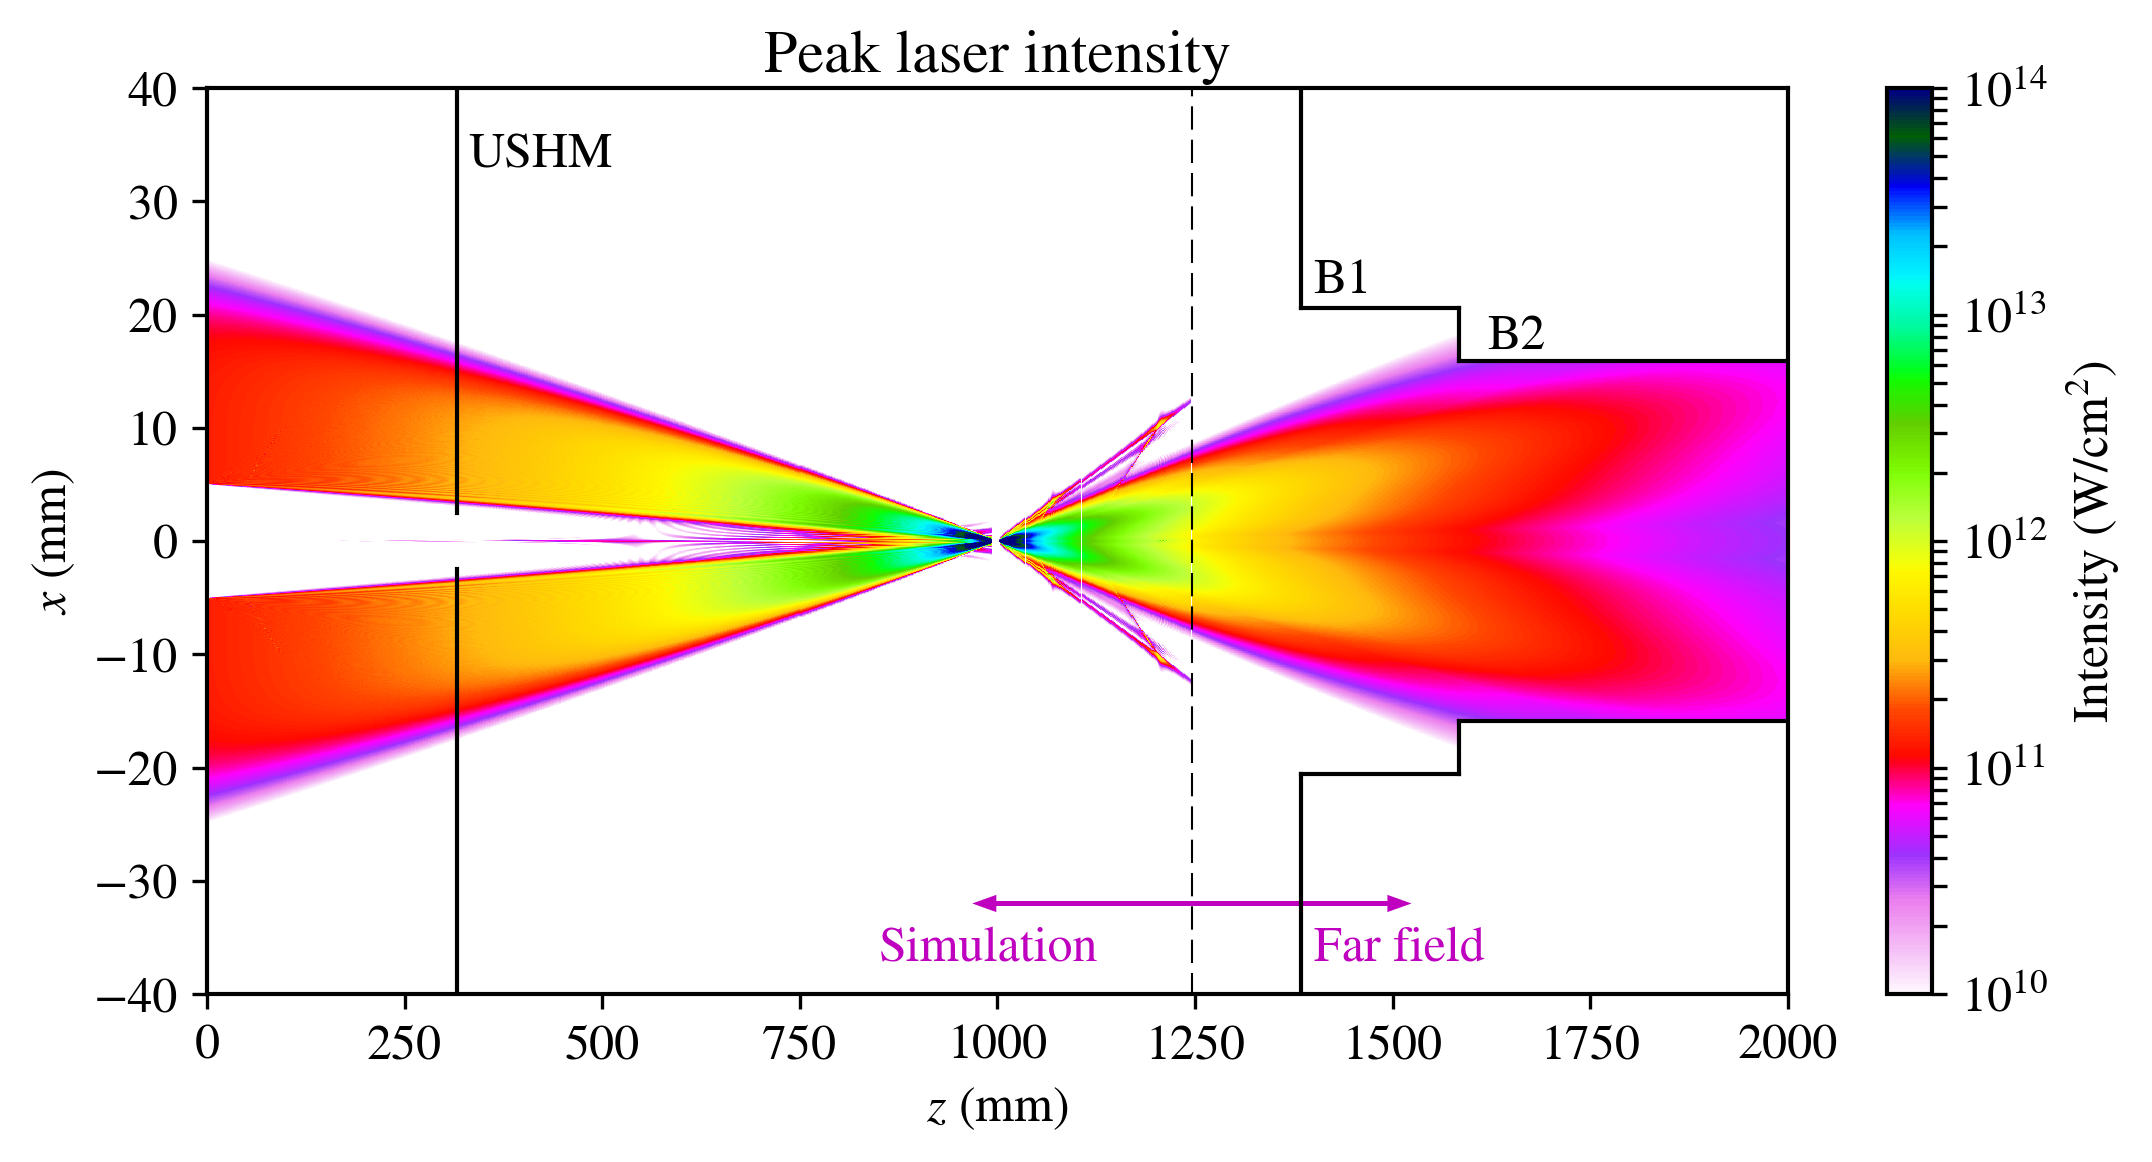

In [59]:
ext0 = [0, Z/1e3, -X_in/2e3, X_in/2e3]

plt.figure(figsize=(8.5, 4), dpi=300)
palette = copy(plt.cm.gist_ncar_r)
palette.set_bad('w', 0.0)
palette.set_under('w', 1.0)
norm = colors.LogNorm(vmin=1e10, vmax=1e14)
for i in range(M+6):
    plt.imshow(Im[i]*1e14, aspect='auto', extent=ext0, norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($\mathrm{W/cm^2}$)')
plt.set_cmap(palette)
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.ylim(-40, 40)
plt.xlim(0, 2000)

# USHM
dz = 316
L = 0
plt.plot([L/1e3+dz, L/1e3+dz], [-50.8, -2.5], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [50.8, 2.5], 'k-', lw=1)
plt.text(330, 33, 'USHM')
# Bypass line
w = w_B1
dz = z_B1
l = 200.4
plt.plot([L/1e3+dz, L/1e3+dz], [-w/2, -60], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [60, w/2], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [-w/2, -w/2], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [w/2, w/2], 'k-', lw=1)
plt.text(1400, 22, 'B1')

w2 = w_B2
dz = z_B2
l = 1000
plt.plot([L/1e3+dz, L/1e3+dz], [-w2/2, -w/2], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [w/2, w2/2], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [-w2/2, -w2/2], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [w2/2, w2/2], 'k-', lw=1)
plt.text(1620, 17, 'B2')

plt.plot([start2/1e3, start2/1e3], [-60, 60], 'k--', lw=0.5)
plt.text(850, -37, 'Simulation', color='m')
plt.text(1400, -37, 'Far field', color='m')
plt.arrow(start2/1e3, -32, 250, 0, head_width=1, head_length=20, color='m')
plt.arrow(start2/1e3, -32, -250, 0, head_width=1, head_length=20, color='m')

plt.show()